In [282]:
#!pip install mat73==0.41
#!pip install seaborn==0.11.0
#!pip install sklearn

In [2]:
%matplotlib inline

import mat73
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
from scipy.stats import *
from scipy.optimize import curve_fit 
from cmath import phase
from numpy import array
from scipy.stats import circmean,circvar,circstd
from matplotlib.pylab import *
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns



In [3]:
# circstats
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return np.nan

def circdist(angles1,angles2):
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

In [172]:
def convert_visdeg2deg2(alpha_x, alpha_y, screen_len):
    '''
    Converts angles of visual degree to angles on circle on screen 

    Parameters
    ----------
    alpha_x : list of array of x-Angle in visual degree for all sessions for one monkey
    alpha_y : list of array of y-Angle in visual degree for all sessions for one monkey
    screen_len : distance between screen and subject

    Returns
    -------
    alpha_full: list of arrays of Angle on working-memory circle in [°] for all sessions for one monkey

    '''
    # calculate tan of each array in list
    x = [np.tan(i) * screen_len for i in alpha_x]#screen_len*np.tan(alpha_x) # convert visual degree to coordinates
    y = [np.tan(i) * screen_len for i in alpha_y]#screen_len*np.tan(alpha_y)
    print(len(x))
    alpha_full = x
    #print(len(x))
    # convert coordinates to angle along circle as in classical WM tasks (0° at top, clockwise)
    for i in range(0,len(x)):# for each session
        # tangens only goes from 0-180, change to 0-360
        idx = np.where(np.logical_or(np.logical_and(x[i]>0, y[i]>0), np.logical_and(x[i]>0, y[i]<0)))
        alpha_full[i][idx] = [0.5*np.pi-np.arctan(y[i][k]/x[i][k]) for k in idx]
        idx = np.where(np.logical_or(np.logical_and(x[i]<0, y[i]<0), np.logical_and(x[i]<0, y[i]>0)))
        alpha_full[i][idx] = [1.5*np.pi-np.arctan(y[i][k]/x[i][k]) for k in idx]
    return [i*180/np.pi for i in alpha_full]

In [222]:
rel_loc = {"a": [], "l": []} 
rel_loc[m].append([circdist(data_sd[m]['target2'][n],data_sd[m]['target1'][n]) for n in range(len(data_sd[m]['target1']))])# relative location current

In [269]:
[np.sign(np.squeeze(rel_loc[m])[i])*err[m][i] for i in range(7)]

[array([ 2.72875740e-01, -2.57921550e-02,  6.33058642e-02, -2.81716672e-03,
         1.26788674e-01,  1.79110448e-01,  7.85893905e-02, -8.23643230e-02,
        -2.24029513e-01,  3.54298494e-02,  2.27216357e-01,  1.84134456e-01,
         4.02553742e-03, -7.85015432e-02, -1.75806284e-02,  7.03304036e-02,
         4.05496427e-03, -8.52095592e-02, -2.24162837e-02, -1.02521790e-01,
        -1.45601429e-01,  3.61397632e-02, -2.01150356e-02,  8.29118843e-01,
         2.87937729e-01, -2.53182778e-01, -1.33315021e-01, -2.56690289e-02,
         5.36991370e-02,  1.78925874e-01, -2.61406227e-01,  3.38679729e-02,
        -2.36396777e-02, -3.63331385e-01, -1.01342482e-02, -1.07274895e-03,
         4.60725458e-02,  1.14201804e-01, -1.64456176e-01, -1.58993200e-01,
        -1.14148058e-02,  1.26913005e-01, -9.82131964e-03, -3.41230662e-01,
        -2.85358750e-01,  4.59888957e-02, -1.32788834e-01, -1.27911492e-01,
         8.78266313e-02,  1.28399993e-01,  2.29129110e-01,  3.93006950e-02,
         7.2

In [270]:
def calc_errorcurve2(results, w1, w2):
    '''
    Calculates serial dependence curve

    Parameters
    ----------
    results :   monkey data for [subject][params][session], with params:
                            target1:   target shown in previous trial
                            target2:   target shown in current trial
                            response1: response given in previous trial
                            response2: response given in current trial
                results : {"a": {"target1": [],"target2": [],"response1": [],"response2": []}, 
                           "l": {"target1": [],"target2": [],"response1": [],"response2": []}}
                w1      : smoothing window width
                w2      : smoothing window shift

    Returns
    -------
    err_avg : average smoothed error per monkey 
    rel_loc_avg : relative location equally spaced in [0,pi]
    err_std : sem of smoothed error
    err : original (unsmoothed) flipped error to (0,pi)

    '''
    rel_loc = {"a": [], "l": []} 
    err = {"a": [], "l": []} 
    err_avg_comb = {"a": [], "l": []} 
    err_std_comb = {"a": [], "l": []} 
    err_avg_single = {"a": [], "l": []} 
    err_std_single = {"a": [], "l": []} 
    for m in ["a", "l"]:
        # calculate serial bias within every session
        rel_loc[m].append([circdist(results[m]['target2'][n],results[m]['target1'][n]) for n in range(len(results[m]['target1']))])# relative location current prvious stimulus
        err[m].append([circdist(results[m]['target2'][n],results[m]['response2'][n]) for n in range(len(results[m]['target1']))])# error current trial
        #print('len err : '+str(len(err[m][0])))
        # create half curve
        err[m] = [np.sign(np.squeeze(rel_loc[m])[i])*np.squeeze(err[m])[i] for i in range(len(np.squeeze(rel_loc[m])))]# flip error along x-axis
        rel_loc[m] = [np.sign(np.squeeze(rel_loc[m])[i])*np.squeeze(rel_loc[m])[i] for i in range(len(np.squeeze(rel_loc[m])))]# flip location along y-axis
        #rel_loc[m] = np.squeeze(rel_loc[m])
        #err[m] = np.squeeze(err[m])
        err_avg_comb[m], err_std_comb[m], err_avg_single[m], err_std_single[m] = mov_avg(rel_loc[m], err[m], w1, w2)
        rel_loc_avg = np.linspace(0,np.pi, int(round(np.pi/w2)))#np.linspace(-np.pi,np.pi, int(round(2*np.pi/w2)))
    # both monkeys combined
    rel_both = np.append(rel_loc['a'],rel_loc['l'])
    err_both = np.append(err['a'],err['l']) 
    err_avg_both, err_std_both, err_avg_both_single, err_std_both_single = mov_avg(rel_both, err_both, w1, w2)
    return err_avg_comb, err_avg_single, rel_loc_avg, err_std_comb, err_std_single, err, rel_loc,\
        err_avg_both, err_avg_both_single, rel_both, err_std_both, err_std_both_single, err_both

def mov_avg(rel_loc, err, w1, w2):
    '''
    Moving average filter 

    Parameters
    ----------
    rel_loc : relative location of stimuli
    err : error of current stimulus
    w1 : width of window
    w2 : shift of window

    Returns
    -------
    err_avg : moving averaged error
    err_std : sem of moving averaged error
    '''     
    err_avg_comb = np.zeros(int(round(np.pi/w2)))#2*
    err_sem_comb = np.zeros(int(round(np.pi/w2)))#2*
    err_avg = []
    err_sem = []
    err_avg_single = np.zeros(int(round(np.pi/w2)))#2*
    err_sem_single = np.zeros(int(round(np.pi/w2)))#2*
    
    # moving average over ALL TRIALS
    rel_loc_comb = np.concatenate(rel_loc)
    err_comb = np.concatenate(err)
    for s in range(0, int(round(np.pi/w2))):#2*
        idx = np.zeros(len(rel_loc_comb))
        for i in range(0,len(rel_loc_comb)):
            if rel_loc_comb[i]> 0+s*w2+(-w1/2) and rel_loc_comb[i]<0+s*w2+(w1/2):#-np.pi
                #err_avg[s] = err_avg[s]+err[i] 
                idx[i]=err_comb[i]
        err_avg_comb[s] = np.median(idx[idx!=0])
        err_sem_comb[s] = sem(idx[idx!=0])
    
    # moving average within each trial    
    for n in range(len(rel_loc)):
        err_avg_single = np.zeros(int(round(np.pi/w2)))#2*
        for s in range(0, int(round(np.pi/w2))):#2*
            idx = np.zeros(len(rel_loc[n]))
            for i in range(0,len(rel_loc[n])):
                if rel_loc[n][i]> 0+s*w2+(-w1/2) and rel_loc[n][i]<0+s*w2+(w1/2):#-np.pi
                    idx[i]=err[n][i]
            #print(rel_loc[0][i])
            #idx = [err[n][i] for n in range(len(rel_loc)) if (rel_loc[n][i]> -np.pi+s*w2+(-w1/2) and rel_loc[n][i]<-np.pi+s*w2+(w1/2))]
            #print(idx)
            err_avg_single[s] = np.median(idx[idx!=0])
            err_sem_single[s] = sem(idx[idx!=0])
        err_avg.append(err_avg_single)
        err_sem.append(err_sem_single)
    return err_avg_comb, err_sem_comb, err_avg, err_sem


In [6]:
def mov_avg_comb(rel_loc_comb, err_comb, w1, w2):
    '''
    Moving average filter for single target cluster

    Parameters
    ----------
    rel_loc_comb : relative location of stimuli
    err_comb : error of current stimulus
    w1 : width of window
    w2 : shift of window

    Returns
    -------
    err_avg_comb : moving averaged error
    err_sem_comb : sem of moving averaged error
    '''     
    err_avg_comb = np.zeros(int(round((max(rel_loc_comb)-min(rel_loc_comb))/w2)))
    err_sem_comb = np.zeros(int(round((max(rel_loc_comb)-min(rel_loc_comb))/w2)))
    rel_loc_avg = np.linspace(min(rel_loc_comb), max(rel_loc_comb), int(round((max(rel_loc_comb)-min(rel_loc_comb))/w2)))
    
    # moving average over ALL TRIALS
    for s in range(0, int(round((max(rel_loc_comb)-min(rel_loc_comb))/w2))):
        idx = np.zeros(len(rel_loc_comb))
        for i in range(0,len(rel_loc_comb)):
            if rel_loc_comb[i]> min(rel_loc_comb)+s*w2+(-w1/2) and rel_loc_comb[i]<min(rel_loc_comb)+s*w2+(w1/2):
                #err_avg[s] = err_avg[s]+err[i] 
                idx[i]=err_comb[i]
        err_avg_comb[s] = np.median(idx[idx!=0])
        err_sem_comb[s] = sem(idx[idx!=0])
    return err_avg_comb, err_sem_comb, rel_loc_avg


### Load data

In [7]:
full_idx = {"a": [], "l": []} 
idx_len = {"a": [], "l": []} 
full_rf = {"a": [], "l": []} 
Counts={"a": [], "l": []} # split data by monkey (a, l)
InFEF={"a": [], "l": []}
Trials = {"a": [], "l": []}
Targets = {"a": ([],[]), "l": ([],[])}
TargetAngle = {"a": ([],[]), "l": ([],[])}
targ_loc = {"a": ([],[]), "l": ([],[])}
SacEnd = {"a": ([],[]), "l": ([],[])}
Responses = {"a": ([],[]), "l": ([],[])}
spikeTimes = {"a": ([]), "l": ([])}
spikeNeurons = {"a": ([]), "l": ([])}
t_fix_start = {"a": ([]), "l": ([])}
t_trial_start = {"a": ([]), "l": ([])}
t_delay_start = {"a": ([]), "l": ([])}
t_delay_end = {"a": ([]), "l": ([])}
t_trial_end = {"a": ([]), "l": ([])}
stim_offset = {"a": ([]), "l": ([])}
t_trial_starttimePLX = {"a": ([]), "l": ([])}
t_trial_starttime = {"a": ([]), "l": ([])}
t_targOn_start = {"a": ([]), "l": ([])}
t_saccade = {"a": ([]), "l": ([])}
t_complete = {"a": ([]), "l": ([])}
t_lastFrame = {"a": ([]), "l": ([])}
for m in ["a","l"]:
    files = np.sort(glob.glob("../Data/%s*.mat" % m))
    for fl in files:
        data_dict = mat73.loadmat(fl)#mat73.loadmat('./Data/a20170517_1230.mat')#
    
        # BEHAVIOR
        idx=data_dict["data"]["trialParams"]["goodtrial"]# completed trials  
        full_idx[m].append(np.asarray(idx))
        idx_len[m].append(len(idx))
        Trials[m].append(sum(idx)) # how many good trials 
        rf = data_dict["data"]["trialParams"]["rfSide"]# receptive field in/out
        full_rf[m].append(rf)
        Counts[m].append(len(data_dict['data']['ROIs'])) # how many regions of interest
        InFEF[m].append(np.sum(np.array(data_dict['data']['ROIs']) == 'FEF'))# how many FEF 
        # x=data_dict["data"]["trialParams"]["targLocX"][idx]# target location in PIXELS  #np.concatenate(data_dict["data"]["trialParams"]["targLocX"][idx])
        # y=data_dict["data"]["trialParams"]["targLocY"][idx]# target location in PIXELS y  #np.concatenate(data_dict["data"]["trialParams"]["targLocY"][idx])
        # Targets[m][0].append(x)
        # Targets[m][1].append(y)
        TarXY = data_dict["data"]["trialParams"]["targXY"]# target position in degrees of visual angle
        TargetAngle[m][0].append(TarXY[:,0])
        TargetAngle[m][1].append(TarXY[:,1])
        # targ_locX = data_dict["data"]["trialParams"]["targLocX"]
        # targ_locY = data_dict["data"]["trialParams"]["targLocY"]
        # targ_loc[m][0].append(targ_locX)
        # targ_loc[m][1].append(targ_locY)
        SacXY = data_dict["data"]["trialParams"]["endEyePosXY"]# saccade end position (response) in degrees of visual angle
        SacEnd[m][0].append(SacXY[:,0])
        SacEnd[m][1].append(SacXY[:,1])
        Err = data_dict["data"]["trialParams"]["xyError"] # 
        Responses[m][0].append(Err[:,0]) # error in x dir
        Responses[m][1].append(Err[:,1]) # error in y dir
    
        # TIMING
        # t_trial_starttimePLX[m].append(data_dict["data"]["trialParams"]["trialEvents"]["trialStartTimePLX"][idx])
        t_trial_starttime[m].append(data_dict["data"]["trialParams"]["trialEvents"]["trialStartTime"])# official start time (for sanity check)
        t_fix_start[m].append(data_dict["data"]["trialParams"]["trialEvents"]["timeFpOn"])
        t_trial_start[m].append(data_dict["data"]["trialParams"]["trialEvents"]["timeFpEntered"])# monkey entered fixation
        # stim_offset[m].append(data_dict["data"]["trialParams"]["trialEvents"]["stimTimeOffset"][idx])# monkey entered fixation
        t_targOn_start[m].append(data_dict["data"]["trialParams"]["trialEvents"]["timeTargetOn"]) # target on + 200ms = target off = delay start
        t_delay_start[m].append(data_dict["data"]["trialParams"]["trialEvents"]["timeTargetOff"]) #
        t_delay_end[m].append(data_dict["data"]["trialParams"]["trialEvents"]["timeFpOff"]) # fixation turned off (GO cue)
        t_saccade[m].append(data_dict["data"]["trialParams"]["trialEvents"]["saccadeTime"])
        t_trial_end[m].append(data_dict["data"]["trialParams"]["trialEvents"]["trialEnd"])
        # t_complete[m].append(data_dict["data"]["trialParams"]["trialEvents"]["timeComplete"][idx])
        # t_lastFrame[m].append(data_dict["data"]["trialParams"]["trialEvents"]["timeLastFrame"][idx])
        print(fl)

../Data/a20170331_1347.mat
../Data/a20170404_1305.mat
../Data/a20170508_1401.mat
../Data/a20170509_1315.mat
../Data/a20170509_1456.mat
../Data/a20170510_1251.mat
../Data/a20170510_1423.mat
../Data/a20170511_1257.mat
../Data/a20170512_1204.mat
../Data/a20170512_1304.mat
../Data/a20170515_1242.mat
../Data/a20170515_1354.mat
../Data/a20170515_1420.mat
../Data/a20170516_1151.mat
../Data/a20170516_1321.mat
../Data/a20170517_1230.mat
../Data/a20170517_1403.mat
../Data/a20170518_1255.mat
../Data/a20170523_1345.mat
../Data/a20170523_1429.mat
../Data/a20170524_1244.mat
../Data/a20170524_1341.mat
../Data/a20170525_1253.mat
../Data/a20170525_1431.mat
../Data/a20170526_1143.mat
../Data/a20170526_1232.mat
../Data/a20170530_1340.mat
../Data/a20170531_1307.mat
../Data/a20170601_1158.mat
../Data/a20170601_1250.mat
../Data/a20170601_1312.mat
../Data/a20170602_1245.mat
../Data/a20170602_1314.mat
../Data/a20170602_1344.mat
../Data/a20170605_1243.mat
../Data/a20170605_1314.mat
../Data/a20170605_1343.mat
.

#### RoFs, trial stats

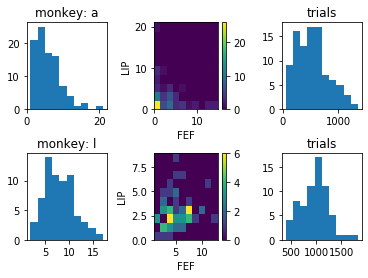

In [8]:
plt.figure()
for i,m in enumerate(["a","l"]): # i runs through numbers (0,1), m through names (a,l)
    plt.subplot(2,3,3*i+1)
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    plt.title("monkey: %s" % m)
    plt.hist(Counts[m])	# histogram of how many regions of interest we have
    plt.subplot(2,3,3*i+2)
    plt.hist2d(InFEF[m],np.array(Counts[m])-np.array(InFEF[m]))	# # of LIP vs FEF
    plt.colorbar()
    plt.xlabel('FEF')
    plt.ylabel('LIP')
    plt.subplot(2,3,3*i+3)
    plt.title("trials") # histogram of how many trials per experiment we have
    plt.hist(Trials[m])
plt.show()


In [9]:
#plt.scatter(TargetAngle[m][0][0][0], TargetAngle[m][1][0][0])

#### Error distribution (completely unfiltered)

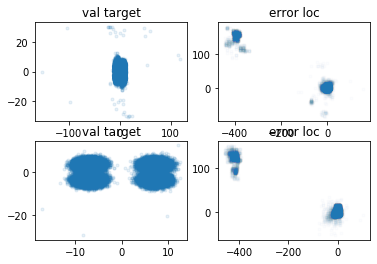

In [9]:
plt.figure()
for i,m in enumerate(["a","l"]):    
    plt.subplot(2,2,2*i+1) # target angle vis deg
    plt.title("val target")
    xVal=np.concatenate(TargetAngle[m][0])
    yVal=np.concatenate(TargetAngle[m][1])
    plt.plot(xVal,yVal,".",alpha=0.1)
    # plt.xlim([-10,10])
    # plt.ylim([-10,10])

    plt.subplot(2,2,2*i+2)
    plt.title("error loc")
    x=np.concatenate(Responses[m][0])
    y=np.concatenate(Responses[m][1])
    plt.plot(x,y,".",alpha=0.01)
    #plt.xlim([-10,10])
    #plt.ylim([-10,10])
plt.show()

#### Convert visual angle to angles on circle

In [10]:
screen_len = 0.57
alphaTrial = {'a': [], 'l': []}
alphaResponse = {'a': [], 'l': []}
alphaCirc = {'a': [], 'l': []}
err = {'a': [], 'l': []}
delay = {'a':[], 'l':[]}

for m in ['a','l']:
    #alphaTrial[m] = convert_visdeg2deg(np.concatenate(TargetAngle[m][0])*np.pi/180, np.concatenate(TargetAngle[m][1])*np.pi/180, screen_len)
    alphaTrial[m] = convert_visdeg2deg2([i * np.pi/180 for i in TargetAngle[m][0]], [i * np.pi/180 for i in TargetAngle[m][1]], screen_len)#
#    alphaResponse[m] = convert_visdeg2deg(np.concatenate(SacEnd[m][0])*np.pi/180, np.concatenate(SacEnd[m][1])*np.pi/180, screen_len)
    alphaResponse[m] = convert_visdeg2deg2([i*np.pi/180 for i in SacEnd[m][0]], [i*np.pi/180 for i in SacEnd[m][1]], screen_len)
    #err[m] = circdist(alphaTrial[m]*np.pi/180, alphaResponse[m]*np.pi/180)*180/np.pi
    err[m] = [circdist(alphaTrial[m][i]*np.pi/180, alphaResponse[m][i]*np.pi/180) for i in range(len(alphaTrial[m]))]
    err[m] = [i*180/np.pi for i in err[m]]
    # delay lengths
    delay[m] = [t_delay_end[m][i]-t_targOn_start[m][i] for i in range(len(t_delay_end[m]))]#(t_delay_start[m])



#### Plot trial position, response position, error size for all trials (° on circle)

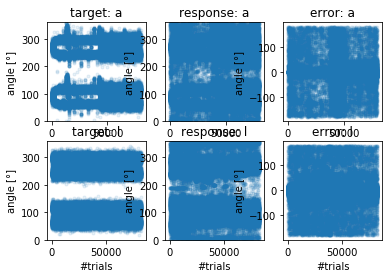

In [12]:
plt.figure()
for i,m in enumerate(["a","l"]):
    plt.subplot(2,3,3*i+1)
    plt.plot(np.concatenate(alphaTrial[m]), '.', alpha=0.1)
    plt.ylim([0,360])
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('target: '+str(m))
    plt.subplot(2,3,3*i+2)
    # ax = plt.subplot(121, projection='polar')
    # ax.plot(alphaResponse['a']*np.pi/180, '.')
    # plt.subplot(122)
    plt.plot(np.concatenate(alphaResponse[m]), '.', alpha=0.1)
    plt.ylim([0,360])
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('response: '+str(m))
    plt.subplot(2,3,3*i+3)
    # ax = plt.subplot(121, projection='polar')
    # ax.plot(err['a']*np.pi/180, '.')
    # plt.subplot(122)
    plt.plot(np.concatenate(err[m]), '.', alpha=0.1)
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('error: '+str(m))
    #plt.ylim([-45,45])
plt.show()

# Determine completed trials, trials within cut-off

In [51]:
cut_off = 25


idx_corr = {'a': [], 'l': []}
TargetAngle_corr = {"a": ([],[]), "l": ([],[])}
SacEnd_corr = {"a": ([],[]), "l": ([],[])}
Responses_corr = {"a": ([],[]), "l": ([],[])}
alphaTrial_corr = {'a': [], 'l': []}
alphaResponse_corr = {'a': [], 'l': []}
err_corr = {'a': [], 'l': []}
delay_corr = {'a': [], 'l': []}
idx_cut = {'a': [], 'l': []}
TargetAngle_cut = {"a": ([],[]), "l": ([],[])}
SacEnd_cut = {"a": ([],[]), "l": ([],[])}
Responses_cut = {"a": ([],[]), "l": ([],[])}
alphaTrial_cut = {'a': [], 'l': []}
alphaResponse_cut = {'a': [], 'l': []}
err_cut = {'a': [], 'l': []}
delay_cut = {'a': [], 'l': []}
cut_short = {'a': [], 'l': []}
err_ds = {'a': [], 'l': []}
delay_ds = {'a': [], 'l': []}
err_dl = {'a': [], 'l': []}
delay_dl = {'a': [], 'l': []}
for m in ['a', 'l']:
    for i in range(len(full_idx[m])):
        idx_help = np.where(full_idx[m][i]==True)
        idx_corr[m].append(np.squeeze(idx_help))
        TargetAngle_corr[m][0].append(TargetAngle[m][0][i][idx_help])
        TargetAngle_corr[m][1].append(TargetAngle[m][1][i][idx_help])
        SacEnd_corr[m][0].append(SacEnd[m][0][i][idx_help])
        SacEnd_corr[m][1].append(SacEnd[m][1][i][idx_help])
        Responses_corr[m][0].append(Responses[m][0][i][idx_help])
        Responses_corr[m][1].append(Responses[m][1][i][idx_help])
        alphaTrial_corr[m].append(alphaTrial[m][i][idx_help])
        alphaResponse_corr[m].append(alphaResponse[m][i][idx_help])
        err_corr[m].append(err[m][i][idx_help])
        delay_corr[m].append(delay[m][i][idx_help])

        idx_help2 = np.where(abs(err_corr[m][i])<cut_off)
        idx_cut[m].append(np.squeeze(idx_help2))
        TargetAngle_cut[m][0].append(TargetAngle_corr[m][0][i][idx_help2])
        TargetAngle_cut[m][1].append(TargetAngle_corr[m][1][i][idx_help2])
        SacEnd_cut[m][0].append(SacEnd_corr[m][0][i][idx_help2])
        SacEnd_cut[m][1].append(SacEnd_corr[m][1][i][idx_help2])
        Responses_cut[m][0].append(Responses_corr[m][0][i][idx_help2])
        Responses_cut[m][1].append(Responses_corr[m][1][i][idx_help2])
        alphaTrial_cut[m].append(alphaTrial_corr[m][i][idx_help2])
        alphaResponse_cut[m].append(alphaResponse_corr[m][i][idx_help2])
        err_cut[m].append(err_corr[m][i][idx_help2])
        delay_cut[m].append(delay_corr[m][i][idx_help2])
for m in ['a', 'l']:
    for i in range(len(full_idx[m])):
        idx_help3 = (delay_cut[m][i]>np.mean(np.concatenate(delay_cut[m])))
        cut_short[m].append(idx_help3)
        err_ds[m].append(err_cut[m][i][np.where(idx_help3==False)])
        delay_ds[m].append(delay_cut[m][i][np.where(idx_help3==False)])
        err_dl[m].append(err_cut[m][i][np.where(idx_help3==True)])
        delay_dl[m].append(delay_cut[m][i][np.where(idx_help3==True)])


In [52]:
print('#Kicked out trials monkey A, goodtrials: '+str(sum([len(TargetAngle['a'][0][i])-len(TargetAngle_corr['a'][0][i]) for i in range(len(TargetAngle['a'][0]))])))
print('#Kicked out trials monkey A, cut_off: '+str(sum([len(TargetAngle_corr['a'][0][i])-len(TargetAngle_cut['a'][0][i]) for i in range(len(TargetAngle['a'][0]))])))
print('#Kicked out trials monkey L, goodtrials : '+str(sum([len(TargetAngle['l'][0][i])-len(TargetAngle_corr['l'][0][i]) for i in range(len(TargetAngle['l'][0]))])))
print('#Kicked out trials monkey L, cut_off: '+str(sum([len(TargetAngle_corr['l'][0][i])-len(TargetAngle_cut['l'][0][i]) for i in range(len(TargetAngle['l'][0]))])))

#Kicked out trials monkey A, goodtrials: 29857
#Kicked out trials monkey A, cut_off: 1696
#Kicked out trials monkey L, goodtrials : 18876
#Kicked out trials monkey L, cut_off: 3503


In [53]:
sum([len(TargetAngle_corr['a'][0][i]) for i in range(len(TargetAngle['a'][0]))])

50266

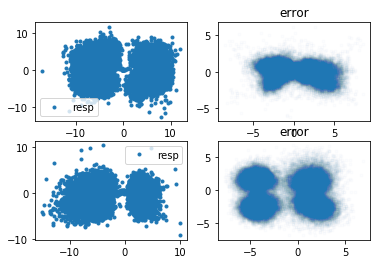

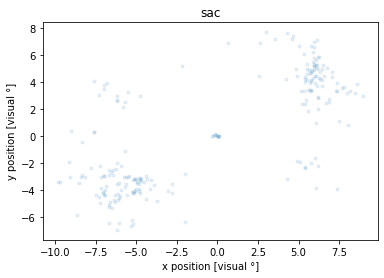

No handles with labels found to put in legend.


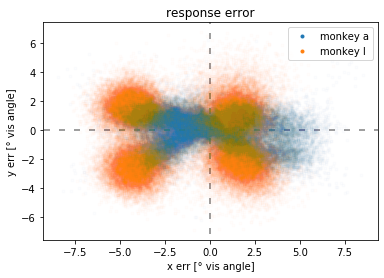

In [55]:
plt.figure()
for i,m in enumerate(["a","l"]):    
    plt.subplot(2,2,2*i+1)
    #xVal=np.concatenate(TargetAngle_cut[m][0])
    #yVal=np.concatenate(TargetAngle_cut[m][1])
    #plt.plot(xVal,yVal,".",alpha=0.01, label = 'tar')
    xVal=np.concatenate(SacEnd_cut[m][0])
    yVal=np.concatenate(SacEnd_cut[m][1])
    plt.plot(xVal,yVal,".",alpha=1, label = 'resp')
    # plt.xlim([-10,10])
    # plt.ylim([-10,10])
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
    plt.subplot(2,2,2*i+2)
    plt.title("error")
    x=np.concatenate(Responses_corr[m][0])
    y=np.concatenate(Responses_corr[m][1])
    plt.plot(x,y,".",alpha=0.01)
    #x= np.concatenate(SacEnd_corr[m][0])-np.concatenate(TargetAngle_corr[m][0])
    #y= np.concatenate(SacEnd_corr[m][1])-np.concatenate(TargetAngle_corr[m][1])
    #plt.plot(x,y,".",alpha=0.01)
    # plt.xlim([-10,10])
    # plt.ylim([-10,10])
plt.show()

plt.figure()
plt.title("sac")
xVal=(SacEnd_cut['a'][0][16])#5, 24, 25, 41,54, 62, 70
yVal=(SacEnd_cut['a'][1][16])#16, 66, 68, 70
plt.plot(xVal,yVal,".",alpha=0.1)
plt.xlabel('x position [visual °]')
plt.ylabel('y position [visual °]')
#plt.savefig('./Target_a20170516_1321.png', dpi=300)
plt.show()

plt.figure()
plt.axhline(0, -5,5, color='grey', dashes = [4,6])
plt.axvline(0, -5,5, color='grey', dashes = [4,6])
x=np.concatenate(Responses_corr['a'][0])
y=np.concatenate(Responses_corr['a'][1])
leg = plt.legend()
plt.plot(x,y,".",alpha=0.01, label='monkey a')
x=np.concatenate(Responses_corr['l'][0])
y=np.concatenate(Responses_corr['l'][1])
plt.plot(x,y,".",alpha=0.01, label='monkey l')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
plt.title('response error')
plt.xlabel('x err [° vis angle]')
plt.ylabel('y err [° vis angle]')
#plt.savefig('../Figures/Behavior/raw_error.png', dpi=100)
plt.show()


### Show target, response position, error for *goodtrials* + within *cut_off*

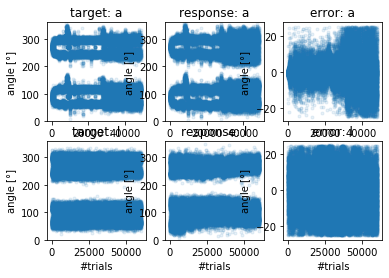

In [17]:
#### show corrected trials
plt.figure()
for i,m in enumerate(["a","l"]):
    plt.subplot(2,3,3*i+1)
    plt.plot(np.concatenate(alphaTrial_cut[m]), '.', alpha=0.1)
    plt.ylim([0,360])
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('target: '+str(m))
    plt.subplot(2,3,3*i+2)
    # ax = plt.subplot(121, projection='polar')
    # ax.plot(alphaResponse['a']*np.pi/180, '.')
    # plt.subplot(122)
    plt.plot(np.concatenate(alphaResponse_cut[m]), '.', alpha=0.1)
    plt.ylim([0,360])
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('response: '+str(m))
    plt.subplot(2,3,3*i+3)
    # ax = plt.subplot(121, projection='polar')
    # ax.plot(err['a']*np.pi/180, '.')
    # plt.subplot(122)
    plt.plot(np.concatenate(err_cut[m]), '.', alpha=0.1)
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('error: '+str(m))
plt.show()

#### circular plot

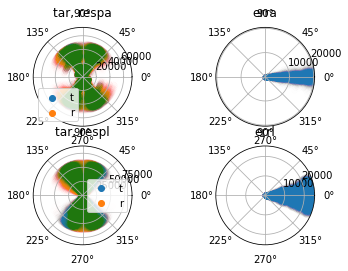

In [18]:
fig = plt.figure()
for i,m in enumerate(["a","l"]):
    theta_trial = np.concatenate(alphaTrial_cut[m])*np.pi/180
    theta_resp = np.concatenate(alphaResponse_cut[m])*np.pi/180
    theta_err = np.concatenate(err_cut[m])*np.pi/180
    
    ax = fig.add_subplot(2,2,2*i+1, projection='polar')
    ax.scatter(theta_trial, np.linspace(0,len(theta_trial), len(theta_trial)), alpha=0.005, label='t')
    ax.scatter(theta_resp, np.linspace(0,len(theta_resp), len(theta_resp)), alpha=0.005, label='r')
    plt.title('tar, resp'+str(m))
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax = fig.add_subplot(2,2,2*i+2, projection='polar')
    ax.scatter(theta_err, np.linspace(0,len(theta_err), len(theta_err)), alpha=0.005)
    plt.title('err'+str(m))
plt.show()

#### Error histograms


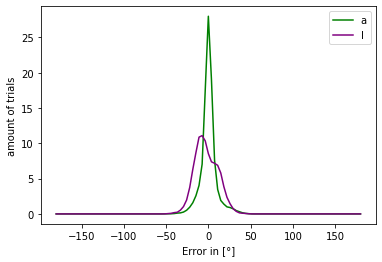

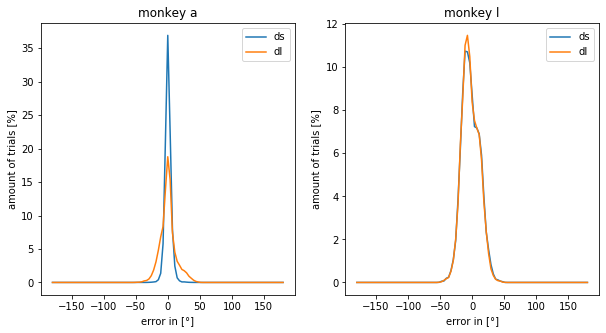

In [50]:
b_num = 100
b = np.linspace(-180,180,b_num)
histo_a=np.histogram(np.concatenate(err_cut['a']), bins=b)
histo_l=np.histogram(np.concatenate(err_cut['l']), bins=b)

plt.figure()
b=np.linspace(-180,180,b_num)
plt.plot(np.linspace(-180,180,b_num-1), histo_a[0]*100/len(np.concatenate(err_cut['a'])), label='a', color='green')
plt.plot(np.linspace(-180,180,b_num-1), histo_l[0]*100/len(np.concatenate(err_cut['l'])), label='l', color='purple')
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.legend()
plt.show()


# delays should be 0.5-2s
plt.figure(figsize=(10,5))
for i,m in enumerate(["a","l"]): 
    plt.subplot(1,2,i+1)
    histo_ds=np.histogram(np.concatenate(err_ds[m]), bins=b)
    histo_dl=np.histogram(np.concatenate(err_dl[m]), bins=b)
    # plt.subplot(2,1,2)
    plt.plot(np.linspace(-180,180,b_num-1), histo_ds[0]*100/len(np.concatenate(err_ds[m])), label='ds')
    plt.plot(np.linspace(-180,180,b_num-1), histo_dl[0]*100/len(np.concatenate(err_dl[m])), label='dl')
    plt.title('monkey '+str(m))
    plt.legend()
    plt.xlabel('error in [°]')
    plt.ylabel('amount of trials [%]')
#plt.savefig('../Figures/Behavior/histogram.png', dpi=100)
plt.show()

### Delay dependence

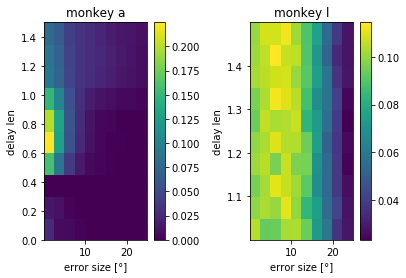

In [20]:
plt.figure()
for i,m in enumerate(['a','l']):
    plt.subplot(1,2,i+1)
    plt.hist2d(abs(np.concatenate(err_cut[m])), np.concatenate(delay_cut[m]),density=True)
    plt.title('monkey '+str(m))
    plt.xlabel('error size [°]')
    plt.ylabel('delay len')
    plt.colorbar()
    plt.subplots_adjust(wspace=0.6)
plt.show()

#### Errors over delay dependence in x/y direction seperately (VISUAL °)

xerr vs delay, a : SpearmanrResult(correlation=0.4917778781045713, pvalue=0.0)
yerr vs delay, a : SpearmanrResult(correlation=0.27027059161176475, pvalue=0.0)


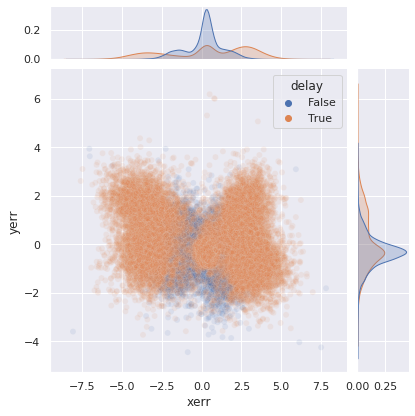

xerr vs delay, l : SpearmanrResult(correlation=-0.04645946259128469, pvalue=3.211056483264559e-30)
yerr vs delay, l : SpearmanrResult(correlation=-0.025029826263047988, pvalue=7.665229434761457e-10)


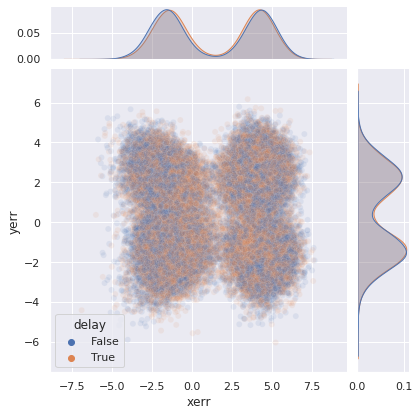

In [117]:
xerr_cut = {'a': [], 'l': []}
yerr_cut = {'a': [], 'l': []}
for i,m in enumerate(['a','l']):
    xerr_cut[m] = circdist(np.concatenate(TargetAngle_cut[m][0])*np.pi/180, np.concatenate(SacEnd_cut[m][0])*np.pi/180)*180/np.pi
    yerr_cut[m] = circdist(np.concatenate(TargetAngle_cut[m][1])*np.pi/180, np.concatenate(SacEnd_cut[m][1])*np.pi/180)*180/np.pi

    print('xerr vs delay, '+str(m)+' : '+str(spearmanr((xerr_cut[m])**2, np.concatenate(delay_cut[m]))))
    print('yerr vs delay, '+str(m)+' : '+str(spearmanr((yerr_cut[m])**2, np.concatenate(delay_cut[m]))))

    xy = {'xerr': xerr_cut[m], 'yerr': yerr_cut[m], 'delay': np.concatenate(cut_short[m])}
    df_xy = pd.DataFrame(xy)

    sns.set_theme()
    sns.jointplot(data=df_xy, x="xerr", y="yerr", hue="delay", marginal_ticks=True, alpha=0.1)# short delay=False, long delay=True
    plt.show()


# Center of mass for target, response

In [56]:
def quadrants(x,y):
    q1 = np.where(np.logical_and(x>0, y>0))
    q2 = np.where(np.logical_and(x<0, y>0))
    q3 = np.where(np.logical_and(x<0, y<0))
    q4 = np.where(np.logical_and(x>0, y<0))
    return q1,q2,q3,q4

import copy

#x_targ = {'a': [], 'l':[]}
#y_targ = {'a': [], 'l':[]}
x_sac= {'a': [], 'l':[]}
y_sac = {'a': [], 'l':[]}
CoMass_targ = {'a': [], 'l':[]}
CoMass_targ_full = {'a': [], 'l':[]}
CoMass_sac = {'a': [], 'l':[]}
CoMass_sac_full = {'a': [], 'l':[]}
TargetAngle_CoMass = copy.deepcopy(TargetAngle_corr)
SacEnd_CoMass = copy.deepcopy(SacEnd_corr)
for m in ['a','l']:
    # Center of mass for each quadrant for target and response
    for n in range(len(TargetAngle_corr[m][0])):
        x_targ = TargetAngle_CoMass[m][0][n]
        y_targ = TargetAngle_CoMass[m][1][n]
        x_sac = SacEnd_CoMass[m][0][n]
        y_sac = SacEnd_CoMass[m][1][n]
        q1, q2, q3, q4 = quadrants(TargetAngle_corr[m][0][n], TargetAngle_corr[m][1][n])
        
        CoMass_targ = [[],[],[],[]]
        CoMass_targ[0] = (np.median(x_targ[np.logical_and(x_targ>0, y_targ>0)]), np.median(y_targ[np.logical_and(x_targ>0, y_targ>0)]))
        CoMass_targ[1] = (np.median(x_targ[np.logical_and(x_targ<0, y_targ>0)]), np.median(y_targ[np.logical_and(x_targ<0, y_targ>0)]))
        CoMass_targ[2] = (np.median(x_targ[np.logical_and(x_targ<0, y_targ<0)]), np.median(y_targ[np.logical_and(x_targ<0, y_targ<0)]))
        CoMass_targ[3] = (np.median(x_targ[np.logical_and(x_targ>0, y_targ<0)]), np.median(y_targ[np.logical_and(x_targ>0, y_targ<0)]))
        CoMass_targ_full[m].append(CoMass_targ)
        CoMass_sac = [[],[],[],[]]
        CoMass_sac[0] = (np.median(x_sac[np.logical_and(x_sac>0, y_sac>0)]), np.median(y_sac[np.logical_and(x_sac>0, y_sac>0)]))
        CoMass_sac[1] = (np.median(x_sac[np.logical_and(x_sac<0, y_sac>0)]), np.median(y_sac[np.logical_and(x_sac<0, y_sac>0)]))
        CoMass_sac[2] = (np.median(x_sac[np.logical_and(x_sac<0, y_sac<0)]), np.median(y_sac[np.logical_and(x_sac<0, y_sac<0)]))
        CoMass_sac[3] = (np.median(x_sac[np.logical_and(x_sac>0, y_sac<0)]), np.median(y_sac[np.logical_and(x_sac>0, y_sac<0)]))
        CoMass_sac_full[m].append(CoMass_sac)
        for idx in [0,1]:
            for i in q1:
                SacEnd_CoMass[m][idx][n][i] = SacEnd_CoMass[m][idx][n][i]+(CoMass_targ[0][idx]-CoMass_sac[0][idx])
            for i in q2:
                SacEnd_CoMass[m][idx][n][i] = SacEnd_CoMass[m][idx][n][i]+(CoMass_targ[1][idx]-CoMass_sac[1][idx])
            for i in q3:
                SacEnd_CoMass[m][idx][n][i] = SacEnd_CoMass[m][idx][n][i]+(CoMass_targ[2][idx]-CoMass_sac[2][idx])
            for i in q4:
                SacEnd_CoMass[m][idx][n][i] = SacEnd_CoMass[m][idx][n][i]+(CoMass_targ[3][idx]-CoMass_sac[3][idx])


{'a': [0, 1, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 17, 18, 19, 21, 23, 26, 27, 30, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 46, 47, 49, 51, 53, 54], 'l': [0, 1, 2, 3, 7, 9, 10, 13, 17, 20]}


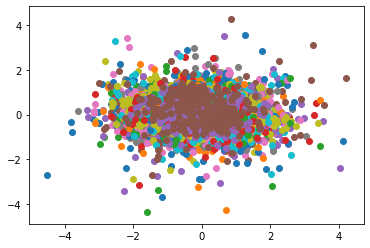

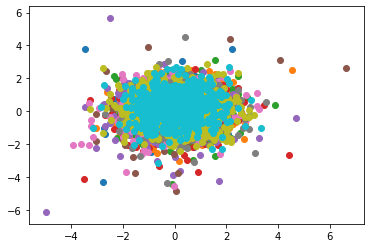

In [26]:
# only use sessions where std(err) is smaller a cut-off value in x/y
cut_std=0.9
sess = {'a': [], 'l': []}
for m in ['a', 'l']:
    sess[m] = [n for n in range(len(SacEnd_CoMass[m][0])) if np.logical_and(abs(std(TargetAngle_CoMass[m][0][n]-SacEnd_CoMass[m][0][n]))<cut_std, abs(std(TargetAngle_CoMass[m][1][n]-SacEnd_CoMass[m][1][n]))<cut_std)]
    plt.figure()
    for n in sess[m]:# # range(len(SacEnd_CoMass[m][0]))
    #n=16
        plt.scatter(TargetAngle_CoMass[m][0][n]-SacEnd_CoMass[m][0][n], TargetAngle_CoMass[m][1][n]-SacEnd_CoMass[m][1][n], label=str(n))
        #plt.legend()
print(sess)


## simulate targets to guess distribution

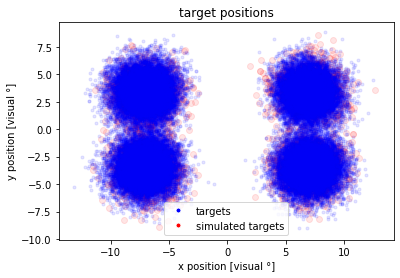

In [19]:
mean_x = np.asarray(CoMass_targ)[:,0]
mean_y = np.asarray(CoMass_targ)[:,1]
sigma=1.5

x_pos = []
y_pos=[]
fig, ax = plt.subplots()

plt.title("target positions")
xVal=np.concatenate(TargetAngle_cut[m][0])
yVal=np.concatenate(TargetAngle_cut[m][1])
plt.plot(xVal,yVal,".",alpha=0.1, color='blue')
for i in range(len(mean_x)):
    x_pos.append(np.random.normal(mean_x[i], sigma, 1000))
    y_pos.append(np.random.normal(mean_y[i], sigma, 1000))
    plt.scatter(x_pos[i], y_pos[i], color='red',alpha=0.1)
plt.xlabel('x position [visual °]')
plt.ylabel('y position [visual °]')
plt.scatter(np.asarray(CoMass_targ)[:,0], np.asarray(CoMass_targ)[:,1])
legend_elements = [Line2D([0], [0], marker='.', color='w',  label='targets',markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='.', color='w', label='simulated targets',
                          markerfacecolor='red', markersize=10)]
ax.legend(handles=legend_elements)
plt.savefig('./TargetPositions.png', dpi=300)
plt.show()


#### plot calculated center of mass original data/manipulated data

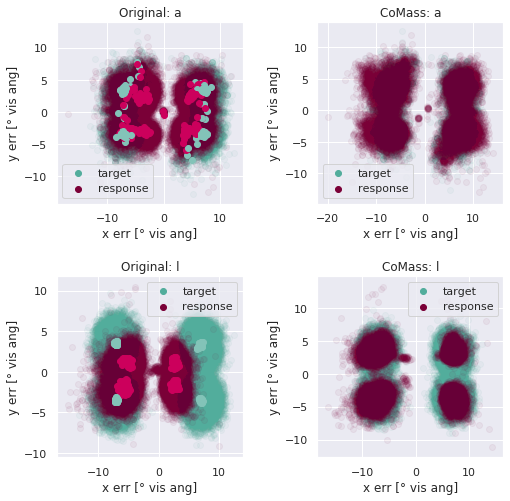

In [314]:
### use all trials
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for idx,m in enumerate(['a','l']):
    plt.subplot(2,2,2*idx+1)
    plt.scatter(np.concatenate(TargetAngle_corr[m][0]), np.concatenate(TargetAngle_corr[m][1]), color='#52AD9C', alpha=0.05, label='target')
    plt.scatter(np.concatenate(SacEnd_corr[m][0]), np.concatenate(SacEnd_corr[m][1]), color='#7A0037', alpha=0.05, label='response')
    for i in range(len(np.concatenate(CoMass_targ_full[m]))):
        plt.scatter(np.concatenate(CoMass_targ_full[m])[i][0], np.concatenate(CoMass_targ_full[m])[i][1], color='#83C3B8')
        plt.scatter(np.concatenate(CoMass_sac_full[m])[i][0], np.concatenate(CoMass_sac_full[m])[i][1], color='#CC005C')
        #print(np.concatenate(CoMass_targ_full[m])[i][0])
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.title('Original: '+str(m))
    plt.xlabel('x err [° vis ang]')
    plt.ylabel('y err [° vis ang]')
    #plt.xlim([5.7,5.8])
    #plt.ylim([3,3.05])
    #plt.savefig('./Figures/HartHuk_Original_'+str(m)+'.png', dpi=300)
    plt.subplot(2,2,2*idx+2)
    plt.scatter(np.concatenate(TargetAngle_CoMass[m][0]), np.concatenate(TargetAngle_CoMass[m][1]), color='#52AD9C', alpha=0.05, label='target')
    plt.scatter(np.concatenate(SacEnd_CoMass[m][0]), np.concatenate(SacEnd_CoMass[m][1]), color='#7A0037', alpha=0.05, label='response')
    plt.title('CoMass: '+str(m))
    plt.xlabel('x err [° vis ang]')
    plt.ylabel('y err [° vis ang]')
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    #plt.savefig('./Figures/HartHuk_CoMass_'+str(m)+'.png', dpi=300)
#    plt.show()
    
    
### only use trials with smallest error std (best trials)
#plt.figure(figsize=(8,8))
#for idx,m in enumerate(['a','l']):
#    plt.subplot(2,2,2*idx+1)
#    plt.scatter(np.concatenate([TargetAngle_corr[m][0][s] for s in sess[m]]), np.concatenate([TargetAngle_corr[m][1][s] for s in sess[m]]), color='#52AD9C', alpha=0.05, label='target')
#    plt.scatter(np.concatenate([SacEnd_corr[m][0][s] for s in sess[m]]), np.concatenate([SacEnd_corr[m][1][s] for s in sess[m]]), color='#7A0037', alpha=0.05, label='response')
#    for i in sess[m]:
#        plt.scatter(np.concatenate(CoMass_targ_full[m])[i][0], np.concatenate(CoMass_targ_full[m])[i][1], color='#83C3B8')
#        plt.scatter(np.concatenate(CoMass_sac_full[m])[i][0], np.concatenate(CoMass_sac_full[m])[i][1], color='#CC005C')
#        #print(np.concatenate(CoMass_targ_full[m])[i][0])
#    leg = plt.legend()
#    for lh in leg.legendHandles: 
#        lh.set_alpha(1)
#    plt.title('Original: '+str(m))
#    #plt.xlim([5.7,5.8])
#    #plt.ylim([3,3.05])
#    #plt.savefig('./Figures/HartHuk_Original_'+str(m)+'.png', dpi=300)
#    
#    plt.subplot(2,2,2*idx+2)
#    plt.scatter(np.concatenate([TargetAngle_CoMass[m][0][s] for s in sess[m]]), np.concatenate([TargetAngle_CoMass[m][1][s] for s in sess[m]]), color='#52AD9C', alpha=0.05, label='target')
#    plt.scatter(np.concatenate([SacEnd_CoMass[m][0][s] for s in sess[m]]), np.concatenate([SacEnd_CoMass[m][1][s] for s in sess[m]]), color='#7A0037', alpha=0.05, label='response')
#    plt.title('CoMass: '+str(m))
#    leg = plt.legend()
#    for lh in leg.legendHandles: 
#        lh.set_alpha(1)
#plt.savefig('../Figures/Behavior/HartHuk_CoMass_'+str(m)+'.png', dpi=300)
plt.show()



#### CoMass correction dependence on delay lengths

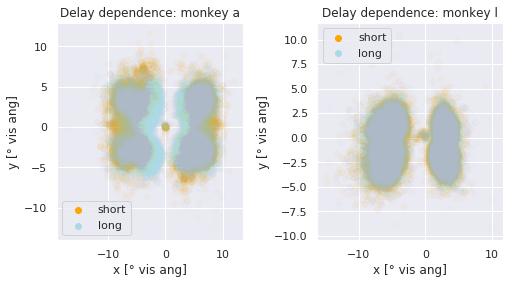

In [319]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.4)
for i,m in enumerate(['a','l']):
    ds = np.concatenate(delay_corr[m])<np.mean(np.concatenate(delay_corr[m]))
    dl = np.concatenate(delay_corr[m])>np.mean(np.concatenate(delay_corr[m]))
    plt.subplot(1,2,i+1)
    #plt.scatter(np.concatenate(TargetAngle_corr[m][0]), np.concatenate(TargetAngle_corr[m][1]), color='grey', alpha=0.05, label='target')
    plt.scatter(np.concatenate(SacEnd_corr[m][0])[ds], np.concatenate(SacEnd_corr[m][1])[ds], color='orange', alpha=0.03, label='short')
    plt.scatter(np.concatenate(SacEnd_corr[m][0])[dl], np.concatenate(SacEnd_corr[m][1])[dl], color='lightblue', alpha=0.03, label='long')
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.title('Delay dependence: monkey '+str(m))
    plt.xlabel('x [° vis ang]')
    plt.ylabel('y [° vis ang]')
    ##plt.xlim([5.7,5.8])
    ##plt.ylim([3,3.05])
    ##plt.savefig('./Figures/HartHuk_Original_'+str(m)+'.png', dpi=300)
    #plt.show()
    
    #plt.figure()
    #plt.scatter(np.concatenate(TargetAngle_CoMass[m][0]), np.concatenate(TargetAngle_CoMass[m][1]), color='grey', alpha=0.05, label='target')
    #plt.scatter(np.concatenate(SacEnd_CoMass[m][0])[ds], np.concatenate(SacEnd_CoMass[m][1])[ds], color='orange', alpha=0.05, label='ds')
    #plt.scatter(np.concatenate(SacEnd_CoMass[m][0])[dl], np.concatenate(SacEnd_CoMass[m][1])[dl], color='lightblue', alpha=0.05, label='dl')
    #plt.title('CoMass: '+str(m))
    #leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
#plt.savefig('../Figures/Behavior/DelayDependence_original.png', dpi=100)
plt.show()



#### Calculate error based on Center of mass distributions

In [15]:
alphaTrial_CoMass = {'a': [], 'l': []}
alphaResponse_CoMass = {'a': [], 'l': []}
alphaCirc_CoMass = {'a': [], 'l': []}
err_CoMass = {'a': [], 'l': []}
### use all sessions
#for m in ['a','l']:
#    alphaTrial_CoMass[m] = convert_visdeg2deg2([i * np.pi/180 for i in TargetAngle_CoMass[m][0]], [i * np.pi/180 for i in TargetAngle_CoMass[m][1]], screen_len)#
#    alphaResponse_CoMass[m] = convert_visdeg2deg2([i*np.pi/180 for i in SacEnd_CoMass[m][0]], [i*np.pi/180 for i in SacEnd_CoMass[m][1]], screen_len)
#    err_CoMass[m] = [circdist(alphaTrial_CoMass[m][i]*np.pi/180, alphaResponse_CoMass[m][i]*np.pi/180) for i in range(len(alphaTrial_CoMass[m]))]
#    err_CoMass[m] = [i*180/np.pi for i in err_CoMass[m]]
  
### ONLY use BEST sessions
for m in ['a','l']:
    alphaTrial_CoMass[m] = convert_visdeg2deg2([[i*np.pi/180 for i in TargetAngle_CoMass[m][0][s]] for s in sess[m]], [[i*np.pi/180 for i in TargetAngle_CoMass[m][1][s]] for s in sess[m]], screen_len)#
    alphaResponse_CoMass[m] = convert_visdeg2deg2([[i*np.pi/180 for i in SacEnd_CoMass[m][0][s]] for s in sess[m]], [[i*np.pi/180 for i in SacEnd_CoMass[m][1][s]] for s in sess[m]], screen_len)
    err_CoMass[m] = [circdist(alphaTrial_CoMass[m][i]*np.pi/180, alphaResponse_CoMass[m][i]*np.pi/180) for i in range(len(alphaTrial_CoMass[m]))]
    err_CoMass[m] = [i*180/np.pi for i in err_CoMass[m]]

### Plots: Center of mass corrected

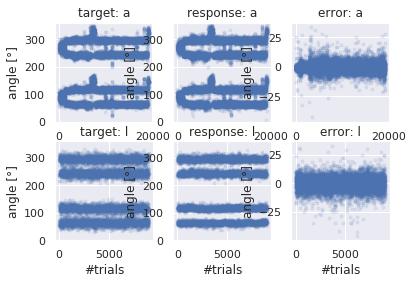

In [26]:
#### show CoMass trials
plt.figure()
for i,m in enumerate(["a","l"]):
    plt.subplot(2,3,3*i+1)
    plt.plot(np.concatenate(alphaTrial_CoMass[m]), '.', alpha=0.1)
    plt.ylim([0,360])
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('target: '+str(m))
    plt.subplot(2,3,3*i+2)
    # ax = plt.subplot(121, projection='polar')
    # ax.plot(alphaResponse['a']*np.pi/180, '.')
    # plt.subplot(122)
    plt.plot(np.concatenate(alphaResponse_CoMass[m]), '.', alpha=0.1)
    plt.ylim([0,360])
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('response: '+str(m))
    plt.subplot(2,3,3*i+3)
    # ax = plt.subplot(121, projection='polar')
    # ax.plot(err['a']*np.pi/180, '.')
    # plt.subplot(122)
    plt.plot(np.concatenate(err_CoMass[m]), '.', alpha=0.1)
    plt.xlabel('#trials')
    plt.ylabel('angle [°]')
    plt.title('error: '+str(m))
plt.show()

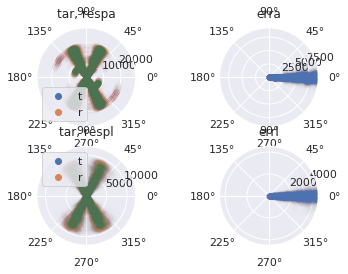

In [27]:
fig = plt.figure()
for i,m in enumerate(["a","l"]):
    theta_trial = np.concatenate(alphaTrial_CoMass[m])*np.pi/180
    theta_resp = np.concatenate(alphaResponse_CoMass[m])*np.pi/180
    theta_err = np.concatenate(err_CoMass[m])*np.pi/180
    
    ax = fig.add_subplot(2,2,2*i+1, projection='polar')
    ax.scatter(theta_trial, np.linspace(0,len(theta_trial), len(theta_trial)), alpha=0.005, label='t')
    ax.scatter(theta_resp, np.linspace(0,len(theta_resp), len(theta_resp)), alpha=0.005, label='r')
    plt.title('tar, resp'+str(m))
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax = fig.add_subplot(2,2,2*i+2, projection='polar')
    ax.scatter(theta_err, np.linspace(0,len(theta_err), len(theta_err)), alpha=0.005)
    plt.title('err'+str(m))
plt.show()

In [24]:
len(idx_help4[i])

818

In [34]:
[SacEnd_CoMass[m][0][s] for s in sess[m]][i]

818

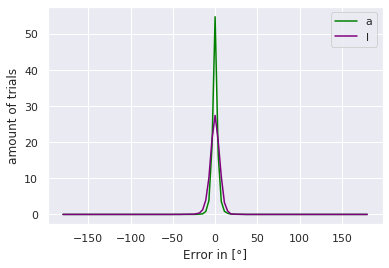

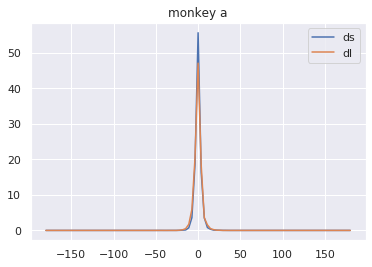

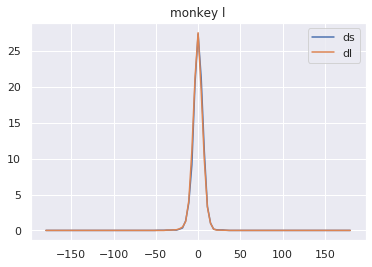

In [37]:
b_num = 100
b = np.linspace(-180,180,b_num)
histo_a=np.histogram(np.concatenate(err_CoMass['a']), bins=b)
histo_l=np.histogram(np.concatenate(err_CoMass['l']), bins=b)

plt.figure()
b=np.linspace(-180,180,b_num)
plt.plot(np.linspace(-180,180,b_num-1), histo_a[0]*100/len(np.concatenate(err_CoMass['a'])), label='a', color='green')
plt.plot(np.linspace(-180,180,b_num-1), histo_l[0]*100/len(np.concatenate(err_CoMass['l'])), label='l', color='purple')
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.legend()
plt.show()


################# DELAY DEPENDENCE

cut_short_CoMass = {'a': [], 'l': []}
err_ds_CoMass = {'a': [], 'l': []}
err_dl_CoMass = {'a': [], 'l': []}
SacEnd_ds_CoMass = {"a": ([],[]), "l": ([],[])}
SacEnd_dl_CoMass = {"a": ([],[]), "l": ([],[])}

### for all trials
#for m in ['a', 'l']:
#    idx_help4 = [delay_corr[m][s]>np.mean(np.concatenate(delay_corr[m])) for s in sess[m]]
#    for i in range(len(err_CoMass[m])):
#        cut_short_CoMass[m].append(idx_help4[i])
#        err_ds_CoMass[m].append(err_CoMass[m][i][np.where(idx_help4[i]==False)])
#        #TargetAngle_ds_CoMass[m].append(TargetAngle_CoMass[m][i][np.where(idx_help4==False)])
#        SacEnd_ds_CoMass[m][0].append(SacEnd_CoMass[m][0][i][np.where(idx_help4[i]==False)])
#        SacEnd_ds_CoMass[m][1].append(SacEnd_CoMass[m][1][i][np.where(idx_help4[i]==False)])
#        err_dl_CoMass[m].append(err_CoMass[m][i][np.where(idx_help4[i]==True)])
#        #TargetAngle_dl_CoMass[m].append(TargetAngle_CoMass[m][i][np.where(idx_help4==True)])
#        SacEnd_dl_CoMass[m][0].append(SacEnd_CoMass[m][0][i][np.where(idx_help4[i]==True)])
#        SacEnd_dl_CoMass[m][1].append(SacEnd_CoMass[m][1][i][np.where(idx_help4[i]==True)])

### for only BEST trials
for m in ['a', 'l']:
    idx_help4 = [delay_corr[m][s]>np.mean(np.concatenate(delay_corr[m])) for s in sess[m]]
    for i in range(len(err_CoMass[m])):
        cut_short_CoMass[m].append(idx_help4[i])
        err_ds_CoMass[m].append(err_CoMass[m][i][np.where(idx_help4[i]==False)])
        #TargetAngle_ds_CoMass[m].append(TargetAngle_CoMass[m][i][np.where(idx_help4==False)])
        SacEnd_ds_CoMass[m][0].append([SacEnd_CoMass[m][0][s] for s in sess[m]][i][np.where(idx_help4[i]==False)])
        SacEnd_ds_CoMass[m][1].append([SacEnd_CoMass[m][1][s] for s in sess[m]][i][np.where(idx_help4[i]==False)])
        err_dl_CoMass[m].append(err_CoMass[m][i][np.where(idx_help4[i]==True)])
        #TargetAngle_dl_CoMass[m].append(TargetAngle_CoMass[m][i][np.where(idx_help4==True)])
        SacEnd_dl_CoMass[m][0].append([SacEnd_CoMass[m][0][s] for s in sess[m]][i][np.where(idx_help4[i]==True)])
        SacEnd_dl_CoMass[m][1].append([SacEnd_CoMass[m][1][s] for s in sess[m]][i][np.where(idx_help4[i]==True)])


# delays should be 0.5-2s
for i,m in enumerate(["a","l"]):     
    plt.figure()
    histo_ds=np.histogram(np.concatenate(err_ds_CoMass[m]), bins=b)
    histo_dl=np.histogram(np.concatenate(err_dl_CoMass[m]), bins=b)
    # plt.subplot(2,1,2)
    plt.plot(np.linspace(-180,180,b_num-1), histo_ds[0]*100/len(np.concatenate(err_ds_CoMass[m])), label='ds')
    plt.plot(np.linspace(-180,180,b_num-1), histo_dl[0]*100/len(np.concatenate(err_dl_CoMass[m])), label='dl')
    plt.title('monkey '+str(m))
    plt.legend()
    plt.show()

abs(circ angle error) vs delay, a : SpearmanrResult(correlation=0.08862422539180465, pvalue=8.877003379927562e-35)
xerr² vs delay, a : SpearmanrResult(correlation=0.10332883399796759, pvalue=1.0213730873828642e-46)
yerr² vs delay, a : SpearmanrResult(correlation=0.03339551028596353, pvalue=3.6977778655917364e-06)
xerr² + yerr² vs delay, a : SpearmanrResult(correlation=0.10600302536260371, pvalue=4.359259667825767e-49)


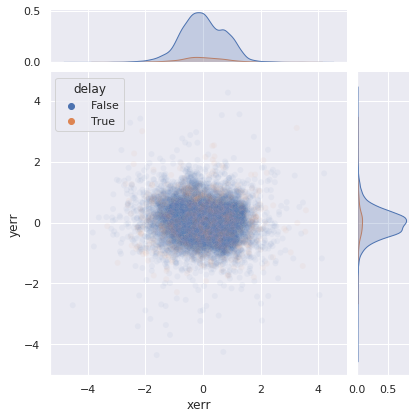

abs(circ angle error) vs delay, l : SpearmanrResult(correlation=0.0054077070260105005, pvalue=0.6071879685502438)
xerr² vs delay, l : SpearmanrResult(correlation=0.017867701154214533, pvalue=0.08936774815328319)
yerr² vs delay, l : SpearmanrResult(correlation=0.010507427147562117, pvalue=0.3178314161663804)
xerr² + yerr² vs delay, l : SpearmanrResult(correlation=0.020450408373859634, pvalue=0.05185481721941307)


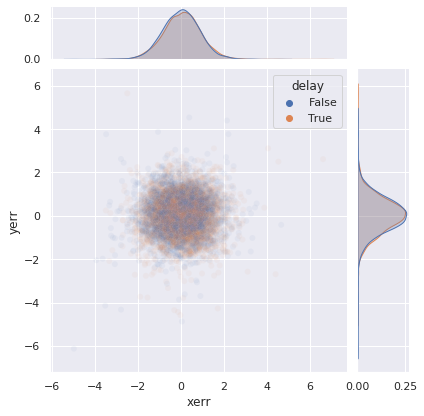

In [38]:
delay_cut_corr = {'a': [], 'l': []}
xerr_CoM = {'a': [], 'l': []}
yerr_CoM = {'a': [], 'l': []}

### for all trials
#for i,m in enumerate(['a','l']):
#    delay_cut_corr[m] = [delay_corr[m][i]>np.mean(np.concatenate(delay_corr[m])) for i in range(len(delay_corr[m]))]

#    xerr_CoM[m] = circdist(np.concatenate(TargetAngle_CoMass[m][0])*np.pi/180, np.concatenate(SacEnd_CoMass[m][0])*np.pi/180)*180/np.pi
#    yerr_CoM[m] = circdist(np.concatenate(TargetAngle_CoMass[m][1])*np.pi/180, np.concatenate(SacEnd_CoMass[m][1])*np.pi/180)*180/np.pi

#    print('abs(circ angle error) vs delay, '+str(m)+' : '+str(spearmanr(abs(np.concatenate(err_CoMass[m])), np.concatenate(delay_corr[m]))))
#    print('xerr² vs delay, '+str(m)+' : '+str(spearmanr((xerr_CoM[m])**2, np.concatenate(delay_corr[m]))))
#    print('yerr² vs delay, '+str(m)+' : '+str(spearmanr((yerr_CoM[m])**2, np.concatenate(delay_corr[m]))))
#    print('xerr² + yerr² vs delay, '+str(m)+' : '+str(spearmanr(((xerr_CoM[m])**2+(yerr_CoM[m])**2), np.concatenate(delay_corr[m]))))

#    xy = {'xerr': xerr_CoM[m], 'yerr': yerr_CoM[m], 'delay': np.concatenate(delay_cut_corr[m])}
#    df_xy = pd.DataFrame(xy)

#    sns.set_theme()
#    sns.jointplot(data=df_xy, x="xerr", y="yerr", hue="delay", marginal_ticks=True, alpha=0.05)# short delay=False, long delay=True
#    plt.show()
  
### ONLY BEST trials
for i,m in enumerate(['a','l']):
    delay_cut_corr[m] = [delay_corr[m][i]>np.mean(np.concatenate(delay_corr[m])) for i in sess[m]]

    xerr_CoM[m] = circdist(np.concatenate([TargetAngle_CoMass[m][0][s] for s in sess[m]])*np.pi/180, np.concatenate([SacEnd_CoMass[m][0][s] for s in sess[m]])*np.pi/180)*180/np.pi
    yerr_CoM[m] = circdist(np.concatenate([TargetAngle_CoMass[m][1][s] for s in sess[m]])*np.pi/180, np.concatenate([SacEnd_CoMass[m][1][s] for s in sess[m]])*np.pi/180)*180/np.pi

    print('abs(circ angle error) vs delay, '+str(m)+' : '+str(spearmanr(abs(np.concatenate(err_CoMass[m])), np.concatenate([delay_corr[m][s] for s in sess[m]]))))
    print('xerr² vs delay, '+str(m)+' : '+str(spearmanr((xerr_CoM[m])**2, np.concatenate([delay_corr[m][s] for s in sess[m]]))))
    print('yerr² vs delay, '+str(m)+' : '+str(spearmanr((yerr_CoM[m])**2, np.concatenate([delay_corr[m][s] for s in sess[m]]))))
    print('xerr² + yerr² vs delay, '+str(m)+' : '+str(spearmanr(((xerr_CoM[m])**2+(yerr_CoM[m])**2), np.concatenate([delay_corr[m][s] for s in sess[m]]))))

    xy = {'xerr': xerr_CoM[m], 'yerr': yerr_CoM[m], 'delay': np.concatenate(delay_cut_corr[m])}
    df_xy = pd.DataFrame(xy)

    sns.set_theme()
    sns.jointplot(data=df_xy, x="xerr", y="yerr", hue="delay", marginal_ticks=True, alpha=0.05)# short delay=False, long delay=True
    plt.show()


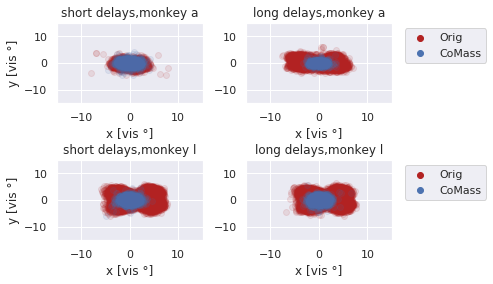

In [54]:
plt.figure()
for i,m in enumerate(['a','l']):
    # plot delay dependence side by side
    subplots_adjust(wspace=0.3, hspace=0.7)
    plt.subplot(2,2,2*i+1)
    plt.scatter((xerr_cut[m][np.concatenate(cut_short[m])==False]), yerr_cut[m][(np.concatenate(cut_short[m])==False)], color='firebrick', alpha=0.1)
    plt.scatter(xerr_CoM[m][np.concatenate(delay_cut_corr[m])==False], yerr_CoM[m][(np.concatenate(delay_cut_corr[m])==False)], alpha=0.1)
    plt.title('short delays,monkey '+str(m))
    plt.xlabel('x [vis °]')
    plt.ylabel('y [vis °]')
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.subplot(2,2,2*i+2)
    plt.scatter((xerr_cut[m][np.concatenate(cut_short[m])]), yerr_cut[m][(np.concatenate(cut_short[m]))], color='firebrick', alpha=0.1, label='Orig')
    plt.scatter(xerr_CoM[m][np.concatenate(delay_cut_corr[m])], yerr_CoM[m][np.concatenate(delay_cut_corr[m])], alpha=0.1, label='CoMass')
    plt.title('long delays,monkey '+str(m))
    plt.xlabel('x [vis °]')
    plt.xlim([-15,15])
    plt.ylim([-15,15])
#plt.savefig('./Figures/Error_LR_mean_CompareOrig.png', dpi=300)
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
plt.show()

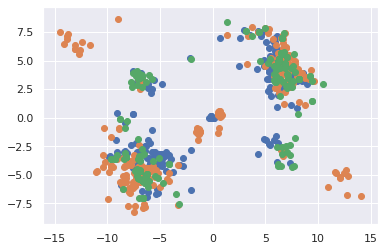

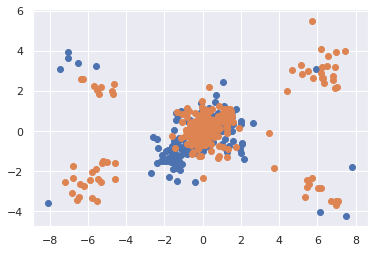

In [80]:
plt.scatter(SacEnd_cut['a'][0][16], SacEnd_cut['a'][1][16])
plt.scatter(SacEnd_CoMass['a'][0][16], SacEnd_CoMass['a'][1][16])
plt.scatter(TargetAngle_cut['a'][0][16], TargetAngle_cut['a'][1][16])
plt.show()
plt.scatter(TargetAngle_cut['a'][0][16]-SacEnd_cut['a'][0][16], TargetAngle_cut['a'][1][16]-SacEnd_cut['a'][1][16])
plt.scatter(TargetAngle_CoMass['a'][0][16]-SacEnd_CoMass['a'][0][16], TargetAngle_CoMass['a'][1][16]-SacEnd_CoMass['a'][1][16])


## Linear Regression for center of mass over delay length

In [71]:
import copy

In [72]:
def quadrants(x,y):
    q1 = [np.where(np.logical_and(x[n]>0, y[n]>0)) for n in range(len(x))]
    q2 = [np.where(np.logical_and(x[n]<0, y[n]>0)) for n in range(len(x))]
    q3 = [np.where(np.logical_and(x[n]<0, y[n]<0)) for n in range(len(x))]
    q4 = [np.where(np.logical_and(x[n]>0, y[n]<0)) for n in range(len(x))]
    #q1 = [np.logical_and(x[n]>0, y[n]>0) for n in range(len(x))]
    #q2 = [np.logical_and(x[n]<0, y[n]>0) for n in range(len(x))]
    #q3 = [np.logical_and(x[n]<0, y[n]<0) for n in range(len(x))]
    #q4 = [np.logical_and(x[n]>0, y[n]<0) for n in range(len(x))]
    return np.squeeze(q1),np.squeeze(q2),np.squeeze(q3),np.squeeze(q4)

q1_lr = {'a': [], 'l': []} 
q2_lr = {'a': [], 'l': []} 
q3_lr = {'a': [], 'l': []} 
q4_lr = {'a': [], 'l': []} 
num_quadr = copy.deepcopy(delay_corr)
for i,m in enumerate(['a','l']):
    q1_lr[m], q2_lr[m], q3_lr[m], q4_lr[m] = quadrants(TargetAngle_corr[m][0], TargetAngle_corr[m][1])
    # TODO: for combination of CoMass+Lr
    #q1_lr[m], q2_lr[m], q3_lr[m], q4_lr[m] = quadrants(TargetAngle_CoMass[m][0], TargetAngle_CoMass[m][1])
    for n in range(len(TargetAngle_corr[m][0])):
        num_quadr[m][n][q1_lr[m][n]] = 1 
        num_quadr[m][n][q2_lr[m][n]] = 2
        num_quadr[m][n][q3_lr[m][n]] = 3 
        num_quadr[m][n][q4_lr[m][n]] = 4 

q_lr = {'q1': q1_lr, 'q2': q2_lr, 'q3':q3_lr, 'q4':q4_lr}


#### create dataframe for lin reg

In [73]:
lst_LR = {"a": {"delay": delay_corr['a'],"targX": TargetAngle_corr['a'][0],"targY": TargetAngle_corr['a'][1],"sacX": SacEnd_corr['a'][0],"sacY": SacEnd_corr['a'][1],"q": num_quadr['a']},\
 "l": {"delay": delay_corr['l'],"targX": TargetAngle_corr['l'][0],"targY": TargetAngle_corr['l'][1],"sacX": SacEnd_corr['l'][0],"sacY": SacEnd_corr['l'][1],"q": num_quadr['l']}}
#lst_LR = {"delay": delay_corr['a'],"targX": TargetAngle_corr['a'][0],"targY": TargetAngle_corr['a'][1],"sacX": SacEnd_corr['a'][0],"sacY": SacEnd_corr['a'][1],"q": num_quadr['a']}
df_LR = pd.DataFrame(lst_LR)

# TODO: for combination of CoMass+Lr
#lst_LR = {"a": {"delay": delay_corr['a'],"targX": TargetAngle_CoMass['a'][0],"targY": TargetAngle_CoMass['a'][1],"sacX": SacEnd_CoMass['a'][0],"sacY": SacEnd_CoMass['a'][1],"q": num_quadr['a']},\
# "l": {"delay": delay_corr['l'],"targX": TargetAngle_CoMass['l'][0],"targY": TargetAngle_CoMass['l'][1],"sacX": SacEnd_CoMass['l'][0],"sacY": SacEnd_CoMass['l'][1],"q": num_quadr['l']}}
##lst_LR = {"delay": delay_corr['a'],"targX": TargetAngle_corr['a'][0],"targY": TargetAngle_corr['a'][1],"sacX": SacEnd_corr['a'][0],"sacY": SacEnd_corr['a'][1],"q": num_quadr['a']}
#df_LR = pd.DataFrame(lst_LR)


## center responses around  0

#### try normalisation

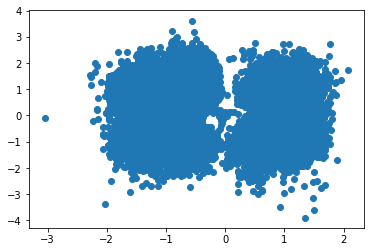

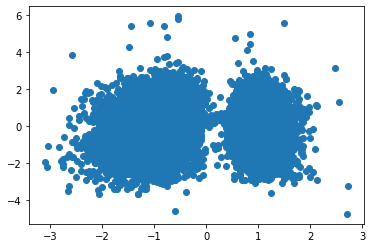

In [74]:
x_mean = {'a':[], 'l':[]}
y_mean = {'a':[], 'l':[]}
for m in ['a','l']:
    x_mean[m] = np.mean(np.concatenate(df_LR[m]['sacX']))#[n] for n in range(len(df_LR[m]['sacX']))])
    y_mean[m] = np.mean(np.concatenate(df_LR[m]['sacY']))#[n] for n in range(len(df_LR[m]['sacX']))])
    plt.figure()
    plt.scatter((np.concatenate(df_LR[m]['sacX'])-x_mean[m])/std(np.concatenate(df_LR[m]['sacX'])), (np.concatenate(df_LR[m]['sacY'])-y_mean[m])/std(np.concatenate(df_LR[m]['sacY'])))

##### -> doesn't work

#### Can determine canter through clustering?

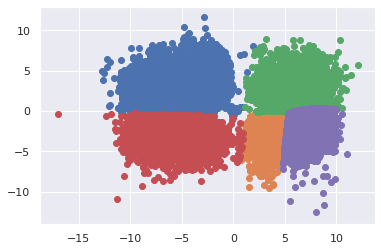

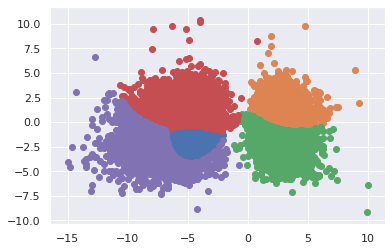

In [60]:
# gaussian mixture clustering
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define dataset
for m in ['a', 'l']:
    X = np.c_[np.concatenate(df_LR[m]['sacX']), np.concatenate(df_LR[m]['sacY'])]
    # define the model
    model = GaussianMixture(n_components=5)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = np.where(yhat == cluster)
        # create scatter of these samples
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
    # show the plot
    pyplot.show()

-> no

#### center monkeys responses around 0 (by hand)

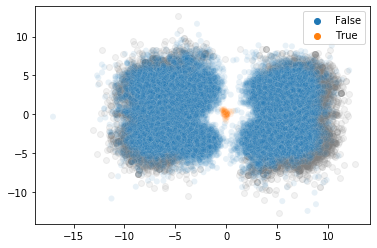

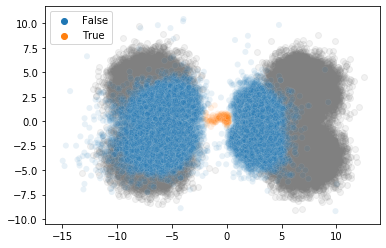

In [75]:
scale_fact = {'a': [0,0], 'l':[0.85, -0.4]}
radius_fact =0.9
df_LR['a']['centerSac'] = (np.sqrt((np.concatenate(df_LR['a']['sacX'])+scale_fact['a'][0])**2 + (np.concatenate(df_LR['a']['sacY'])+scale_fact['a'][1])**2)<radius_fact)
radius_fact = 1.3
df_LR['l']['centerSac'] = (np.sqrt((np.concatenate(df_LR['l']['sacX'])+scale_fact['l'][0])**2 + (np.concatenate(df_LR['l']['sacY'])+scale_fact['l'][1])**2)<radius_fact)

for m in ['a','l']:
    plt.figure()
    plt.scatter(np.concatenate(df_LR[m]['targX']), np.concatenate(df_LR[m]['targY']), color='grey', alpha=0.1)
    sns.scatterplot(x=np.concatenate(df_LR[m]['sacX']), y=np.concatenate(df_LR[m]['sacY']), hue = df_LR[m]['centerSac'], alpha=0.1)
    plt.show()

#### determine saccade offset, subtract from all points

In [76]:
for m in ['a', 'l']:
    x_off = np.mean(np.concatenate(df_LR[m]['sacX'])[df_LR[m]['centerSac']])
    y_off = np.mean(np.concatenate(df_LR[m]['sacY'])[df_LR[m]['centerSac']])
    print(x_off)
    print(y_off)
    df_LR[m]['sacX_off'] = [df_LR[m]['sacX'][n]-x_off for n in range(len(df_LR[m]['sacX']))]#df_LR[m]['sacX'] + x_off + scale_fact[m][0]
    df_LR[m]['sacY_off'] = [df_LR[m]['sacY'][n]-y_off for n in range(len(df_LR[m]['sacY']))]#df_LR[m]['sacY'] + y_off + scale_fact[m][1]
    # TODO: NO adjustment for mean of center
    #df_LR[m]['sacX_off'] = df_LR[m]['sacX']
    #df_LR[m]['sacY_off'] = df_LR[m]['sacY']
    #print('new offset x: '+str(np.mean(np.concatenate(df_LR[m]['sacX_off'])[df_LR[m]['centerSac']])))
    #print('new offset x: '+str(np.mean(np.concatenate(df_LR[m]['sacY_off'])[df_LR[m]['centerSac']])))

-0.05600821641106053
0.09637456445802606
-0.523830120318141
0.25261923189063523


##### check if correct

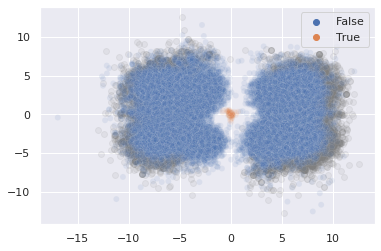

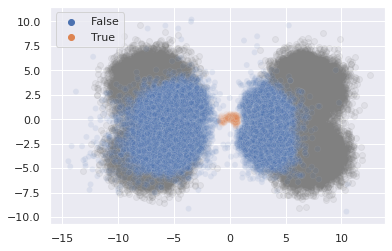

In [44]:
for m in ['a','l']:
    df_LR[m]['centerSac'] = (np.sqrt((np.concatenate(df_LR[m]['sacX_off']))**2 + np.concatenate(df_LR[m]['sacY_off'])**2)<1)
    plt.figure()
    plt.scatter(np.concatenate(df_LR[m]['targX']), np.concatenate(df_LR[m]['targY']), color='grey', alpha=0.1)
    sns.scatterplot(x = np.concatenate(df_LR[m]['sacX_off']), y=np.concatenate(df_LR[m]['sacY_off']), hue = df_LR[m]['centerSac'], alpha=0.1)
    #plt.xlim([-1,1])
    #plt.ylim([-1,1])
    plt.show()
    

#### -> new points to work with, centered around 0

# Linear Regression

In [77]:
from sklearn.linear_model import LinearRegression
X_delay = {'a': [], 'l': []} 
Targ_q = {'a': ([],[]), 'l': ([],[])} 
y_Sac = {'a': ([],[]), 'l': ([],[])} 
a_x = {'a': [], 'l': []} 
a_y = {'a': [], 'l': []} 
b_x = {'a': [], 'l': []} 
b_y = {'a': [], 'l': []} 
for i,m in enumerate(['a', 'l']):
    for qi, q in enumerate(['q1','q2','q3','q4']):
        X_delay[m].append(np.c_[np.concatenate(df_LR[m]['delay'])[np.concatenate(df_LR[m]['q'])==qi+1]])
        y_Sac[m][0].append(np.c_[np.concatenate(df_LR[m]['sacX_off'])[np.concatenate(df_LR[m]['q'])==qi+1]])
        y_Sac[m][1].append(np.c_[np.concatenate(df_LR[m]['sacY_off'])[np.concatenate(df_LR[m]['q'])==qi+1]])
        reg_x = LinearRegression().fit(X_delay[m][qi], y_Sac[m][0][qi])
        reg_y = LinearRegression().fit(X_delay[m][qi], y_Sac[m][1][qi])

        a_x[m].append(np.squeeze(reg_x.coef_))
        b_x[m].append(reg_x.intercept_)
        a_y[m].append(np.squeeze(reg_y.coef_))
        b_y[m].append(reg_y.intercept_)

        Targ_q[m][0].append(np.concatenate(df_LR[m]['targX'])[np.concatenate(df_LR[m]['q'])==qi+1])
        Targ_q[m][1].append(np.concatenate(df_LR[m]['targY'])[np.concatenate(df_LR[m]['q'])==qi+1])


print(a_x,b_x)

{'a': [array(-1.71916685), array(3.07819089), array(3.15171752), array(-2.07438486)], 'l': [array(0.50875693), array(-0.79220349), array(-0.69659326), array(0.67491433)]} {'a': [array([7.3693071]), array([-8.29384865]), array([-8.18220734]), array([7.21137922])], 'l': [array([2.66222436]), array([-3.89685518]), array([-4.37739035]), array([2.28883747])]}


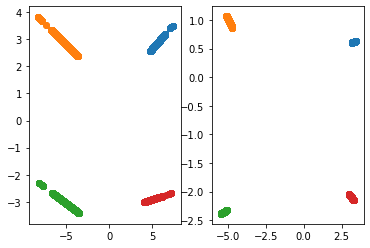

In [78]:
# plot slopes of linear regression results
plt.figure()
for i,m in enumerate(['a', 'l']):
    plt.subplot(1,2,i+1)
    for qi,q in enumerate(['q1','q2','q3','q4']):
        plt.scatter(a_x[m][qi]*X_delay[m][qi]+b_x[m][qi], a_y[m][qi]*X_delay[m][qi]+b_y[m][qi])
plt.show()

#### determine shifting factor, shift responses

In [79]:
#radius_LR = copy.deepcopy()#{'a':[], 'l':[]}# radius for each trial in each quadrant r[m][0]=q1, r[m][1]=q2,...
#radius_targ = {'a':[], 'l':[]}#
#Xi = {'a':[], 'l':[]}#
#Xi_mean = {'a':[], 'l':[]}#
#Sac_end_LR = {'a':([],[]), 'l':([],[])}
#Sac_end_LR_mean = {'a':([],[]), 'l':([],[])}


for m in ['a', 'l']:
    Xi = copy.deepcopy(df_LR[m]['q'])
    Xi_mean = copy.deepcopy(df_LR[m]['q'])
    for qi,q in enumerate(['q1','q2','q3','q4']):# in each quadrant
        # get radius from center of responses determined through LR: r = sqrt((x_i)²+(y_i)²)
        radius_LR = [np.sqrt((a_x[m][qi]*df_LR[m]['delay'][n][df_LR[m]['q'][n]==qi+1]+b_x[m][qi])**2+(a_y[m][qi]*df_LR[m]['delay'][n][df_LR[m]['q'][n]==qi+1]+b_y[m][qi])**2) for n in range(len(df_LR[m]['q']))]
        # get target radius for each trial
        radius_targ = [np.sqrt(df_LR[m]['targX'][n][df_LR[m]['q'][n]==qi+1]**2 + df_LR[m]['targY'][n][df_LR[m]['q'][n]==qi+1]**2) for n in range(len(df_LR[m]['q']))]
        # determine shifting factor target_radius/radius_LR
        for n in range(len(df_LR[m]['q'])):
            Xi[n][np.squeeze(np.where(df_LR[m]['q'][n]==qi+1))] = radius_targ[n]/radius_LR[n]
            Xi_mean[n][np.squeeze(np.where(df_LR[m]['q'][n]==qi+1))] = np.median(radius_targ[n])/radius_LR[n]
        # determine new reponse coordinates: Xi*Sac x/y
    df_LR[m]['sacX_LR'] = [df_LR[m]['sacX_off'][n]*Xi[n] for n in range(len(df_LR[m]['q']))]
    df_LR[m]['sacX_LR_mean'] = [df_LR[m]['sacX_off'][n]*Xi_mean[n] for n in range(len(df_LR[m]['q']))]
    df_LR[m]['sacY_LR'] = [df_LR[m]['sacY_off'][n]*Xi[n] for n in range(len(df_LR[m]['q']))]
    df_LR[m]['sacY_LR_mean'] = [df_LR[m]['sacY_off'][n]*Xi_mean[n] for n in range(len(df_LR[m]['q']))]
        #Sac_end_LR[m][0].append(np.squeeze(y_Sac[m][0][qi])*Xi[m][qi])
        #Sac_end_LR[m][1].append(np.squeeze(y_Sac[m][1][qi])*Xi[m][qi])
        #Sac_end_LR_mean[m][0].append(np.squeeze(y_Sac[m][0][qi])*Xi[m][qi])
        #Sac_end_LR_mean[m][1].append(np.squeeze(y_Sac[m][1][qi])*Xi_mean[m][qi])


#### only use best trials

{'a': [0, 1, 3, 5, 6, 7, 9, 13, 14, 15, 17, 25, 26, 27, 30, 33, 37, 38, 40, 42, 43], 'l': [0, 4, 17, 27, 54, 55, 56]}


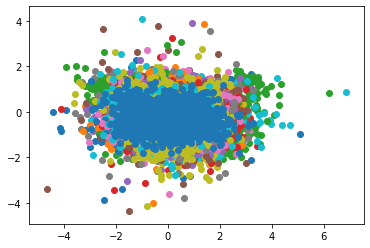

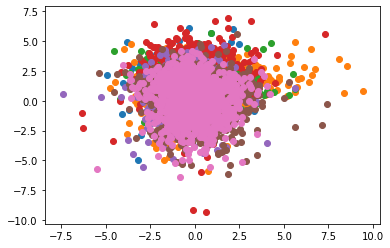

In [81]:
# only use sessions where std(err) is smaller a cut-off value in x/y
cut_std=0.03
sess_corr = {'a': [], 'l': []}
for m in ['a', 'l']:
    # session is chosen if error in x, error in y < cut_std
    #seperate in x/y
    #sess_corr[m] = [n for n in range(len(df_LR[m]['sacX_LR_mean'])) if np.logical_and(abs(std(TargetAngle_corr[m][0][n]-df_LR[m]['sacX_LR_mean'][n]))<cut_std, abs(std(TargetAngle_corr[m][1][n]-df_LR[m]['sacY_LR_mean'][n]))<cut_std)]
    #using radius of x,y
    sess_corr[m] = [n for n in range(len(df_LR[m]['sacX_LR_mean'])) if sem(np.sqrt((TargetAngle_corr[m][0][n]-df_LR[m]['sacX_LR_mean'][n])**2 + (TargetAngle_corr[m][1][n]-df_LR[m]['sacY_LR_mean'][n])**2))<cut_std]
    plt.figure()
    for n in sess_corr[m]:# # range(len(SacEnd_CoMass[m][0]))
    #n=16
        plt.scatter(TargetAngle_corr[m][0][n]-df_LR[m]['sacX_LR_mean'][n], TargetAngle_corr[m][1][n]-df_LR[m]['sacY_LR_mean'][n], label=str(n))
        df_LR[m]['sacX_LR_mean']
        #plt.legend()
print(sess_corr)


In [87]:
len(TargetAngle_cut['a'][0])

94

[0, 4, 17, 27, 54, 55, 56]

#### compare original, linear regressed responses

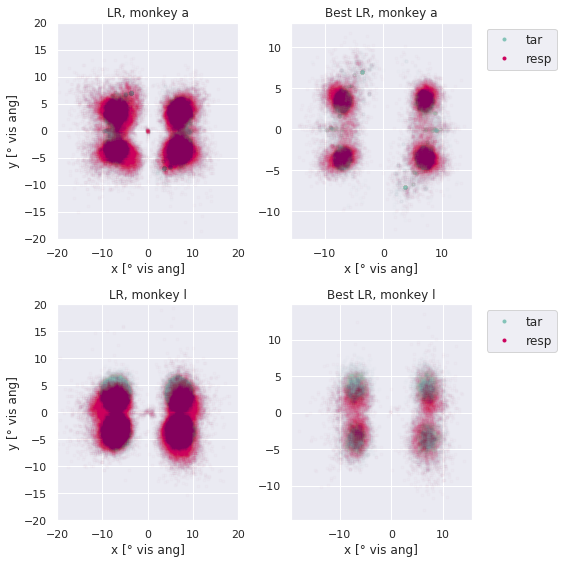

In [324]:
plt.figure(figsize=(8,8))
for i,m in enumerate(["a","l"]): 
    plt.subplots_adjust(wspace=0.3, hspace=0.7)
    #plt.subplot(2,3,3*i+1)
    plt.subplot(2,2,2*i+1)
    xVal=np.concatenate(TargetAngle_cut[m][0])
    yVal=np.concatenate(TargetAngle_cut[m][1])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#83C3B8', label = 'target')
    xVal=np.concatenate(SacEnd_cut[m][0])
    yVal=np.concatenate(SacEnd_cut[m][1])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#CC005C', label = 'saccade')
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.title('Orig, monkey '+str(m))
    plt.xlabel('x [° vis ang]')
    plt.ylabel('y [° vis ang]')
        
    #plt.subplot(2,3,3*i+2)
    #plt.subplot(2,2,2*i+2)
    plt.subplot(2,2,2*i+1)
    xVal=np.concatenate(TargetAngle_cut[m][0])
    yVal=np.concatenate(TargetAngle_cut[m][1])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#83C3B8', label = 'target')
    xVal=np.concatenate(df_LR[m]['sacX_LR_mean'])
    yVal=np.concatenate(df_LR[m]['sacY_LR_mean'])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#CC005C', label = 'saccade')
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.title('LR, monkey '+str(m))
    #leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #for lh in leg.legendHandles: 
    #    lh._legmarker.set_alpha(1)
    plt.xlabel('x [° vis ang]')
    plt.ylabel('y [° vis ang]')

       
    #plt.subplot(2,3,3*i+3)
    plt.subplot(2,2,2*i+2)
    xVal=np.concatenate([TargetAngle_cut[m][0][i] for i in sess_corr[m]])
    yVal=np.concatenate([TargetAngle_cut[m][1][i] for i in sess_corr[m]])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#83C3B8', label = 'tar')
    xVal=np.concatenate([df_LR[m]['sacX_LR_mean'][i] for i in sess_corr[m]])
    yVal=np.concatenate([df_LR[m]['sacY_LR_mean'][i] for i in sess_corr[m]])
    #xVal=np.concatenate(Sac_end_LR[m][0])
    #yVal=np.concatenate(Sac_end_LR[m][1])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#CC005C',label = 'resp')
    #plt.xlim([-20,20])
    #plt.ylim([-20,20])
    plt.title('Best LR, monkey '+str(m))
    plt.xlabel('x [° vis ang]')


    #leg = plt.legend()
    #for lh in leg.legendHandles: 
    #    lh._legmarker.set_alpha(1)
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
plt.tight_layout()
#plt.savefig('../Figures/Behavior/LinearRegressed_TargetResponse_best.png', dpi=100)
plt.show()


#### test delay dependence

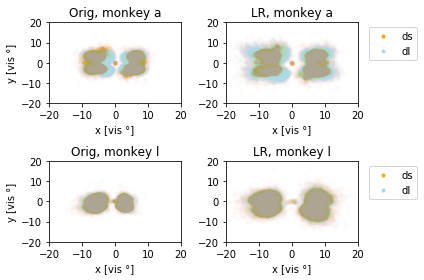

In [105]:
plt.figure()
for i,m in enumerate(["a","l"]): 
    ds = np.concatenate(delay_corr[m]) < np.mean(np.concatenate(delay_corr[m]))
    dl = np.concatenate(delay_corr[m]) > np.mean(np.concatenate(delay_corr[m]))
    
    plt.subplots_adjust(wspace=0.3, hspace=0.7)
    plt.subplot(2,2,2*i+1)
    #xVal=np.concatenate(TargetAngle_corr[m][0])
    #yVal=np.concatenate(TargetAngle_corr[m][1])
    #plt.plot(xVal,yVal,".",alpha=0.01, label = 'tar')
    xVal=np.concatenate(SacEnd_corr[m][0])[ds]
    yVal=np.concatenate(SacEnd_corr[m][1])[ds]
    plt.plot(xVal,yVal,".",alpha=0.01, color='orange',label = 'ds')
    xVal=np.concatenate(SacEnd_corr[m][0])[dl]
    yVal=np.concatenate(SacEnd_corr[m][1])[dl]
    plt.plot(xVal,yVal,".",alpha=0.01, color='lightblue', label = 'dl')
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.title('Orig, monkey '+str(m))
    plt.xlabel('x [vis °]')
    plt.ylabel('y [vis °]')
        
    plt.subplot(2,2,2*i+2)
    #xVal=np.concatenate(TargetAngle_corr[m][0])
    #yVal=np.concatenate(TargetAngle_corr[m][1])
    #plt.plot(xVal,yVal,".",alpha=0.01, label = 'tar')
    xVal=np.concatenate(df_LR[m]['sacX_LR_mean'])[ds]
    yVal=np.concatenate(df_LR[m]['sacY_LR_mean'])[ds]
    plt.plot(xVal,yVal,".",alpha=0.01, color='orange', label = 'ds')
    xVal=np.concatenate(df_LR[m]['sacX_LR_mean'])[dl]
    yVal=np.concatenate(df_LR[m]['sacY_LR_mean'])[dl]
    plt.plot(xVal,yVal,".",alpha=0.01, color='lightblue', label = 'dl')
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.title('LR, monkey '+str(m))
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
    plt.xlabel('x [vis °]')
            
    #plt.subplot(2,3,3*i+3)
    #xVal=np.concatenate(TargetAngle_cut[m][0])
    #yVal=np.concatenate(TargetAngle_cut[m][1])
    #plt.plot(xVal,yVal,".",alpha=0.01, label = 'tar')
    #xVal=np.concatenate(Sac_end_LR[m][0])
    #yVal=np.concatenate(Sac_end_LR[m][1])
    #plt.plot(xVal,yVal,".",alpha=0.01, label = 'resp')
    #plt.xlim([-20,20])
    #plt.ylim([-20,20])
    #plt.title('LR, monkey '+str(m))
    #leg = plt.legend()
    #for lh in leg.legendHandles: 
    #    lh._legmarker.set_alpha(1)
plt.tight_layout()
#plt.savefig('./Figures/LinearRegressed_TargetSacPos.png', dpi=300)
plt.show()


### delay dependence of linear regressed saccade 

xerr vs delay, a : SpearmanrResult(correlation=0.10912974351237015, pvalue=3.1437894641098856e-47)
yerr vs delay, a : SpearmanrResult(correlation=0.20016253864940453, pvalue=1.1572621531672971e-156)


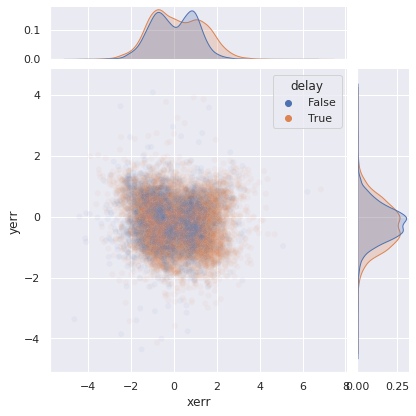

xerr vs delay, l : SpearmanrResult(correlation=0.01404341681544221, pvalue=0.17780656528515848)
yerr vs delay, l : SpearmanrResult(correlation=-0.017339811579166142, pvalue=0.09613465078041696)


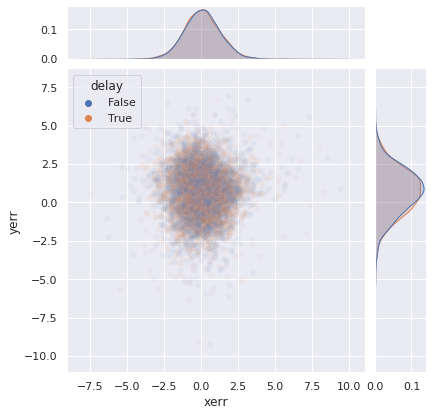

In [106]:
cut_short_LR = {'a':[], 'l':[]}
xerr_mean = {'a':[], 'l':[]}
yerr_mean = {'a':[], 'l':[]}
for i,m in enumerate(['a','l']):
    # determine trials short/long, cut-off along mean
    #cut_short_LR[m] = (np.concatenate(df_LR[m]['delay'])>np.mean(np.concatenate(df_LR[m]['delay'])))
    cut_short_LR[m] = (np.concatenate([df_LR[m]['delay'][i] for i in sess_corr[m]])>np.mean(np.concatenate([df_LR[m]['delay'][i] for i in sess_corr[m]])))
    
    # calculate errors
    #xerr_mean[m] = circdist(np.concatenate(df_LR[m]['targX'])*np.pi/180, np.concatenate(df_LR[m]['sacX_LR_mean'])*np.pi/180)*180/np.pi
    #yerr_mean[m] = circdist(np.concatenate(df_LR[m]['targY'])*np.pi/180, np.concatenate(df_LR[m]['sacY_LR_mean'])*np.pi/180)*180/np.pi
    xerr_mean[m] = circdist(np.concatenate([df_LR[m]['targX'][i] for i in sess_corr[m]])*np.pi/180, np.concatenate([df_LR[m]['sacX_LR_mean'][i] for i in sess_corr[m]])*np.pi/180)*180/np.pi
    yerr_mean[m] = circdist(np.concatenate([df_LR[m]['targY'][i] for i in sess_corr[m]])*np.pi/180, np.concatenate([df_LR[m]['sacY_LR_mean'][i] for i in sess_corr[m]])*np.pi/180)*180/np.pi

    #print('xerr vs delay, '+str(m)+' : '+str(spearmanr((xerr_mean[m])**2, np.concatenate(df_LR[m]['delay']))))
    #print('yerr vs delay, '+str(m)+' : '+str(spearmanr((yerr_mean[m])**2, np.concatenate(df_LR[m]['delay']))))
    print('xerr vs delay, '+str(m)+' : '+str(spearmanr((xerr_mean[m])**2, np.concatenate([df_LR[m]['delay'][i] for i in sess_corr[m]]))))
    print('yerr vs delay, '+str(m)+' : '+str(spearmanr((yerr_mean[m])**2, np.concatenate([df_LR[m]['delay'][i] for i in sess_corr[m]]))))

    xy = {'xerr': xerr_mean[m], 'yerr': yerr_mean[m], 'delay': cut_short_LR[m]}
    df_xy = pd.DataFrame(xy)

    sns.set_theme()
    sns.jointplot(data=df_xy, x="xerr", y="yerr", hue="delay", marginal_ticks=True, alpha=0.05)# short delay=False, long delay=True
    plt.show()


#### compare original errors, linear regressed errors

NameError: name 'xerr_cut' is not defined

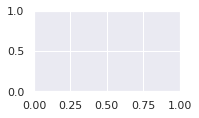

In [107]:
plt.figure()
for i,m in enumerate(['a','l']):
    # plot delay dependence side by side
    subplots_adjust(wspace=0.3, hspace=0.7)
    plt.subplot(2,2,2*i+1)
    plt.scatter((xerr_cut[m][np.concatenate(cut_short[m])==False]), yerr_cut[m][(np.concatenate(cut_short[m])==False)], color='firebrick', alpha=0.1)
    plt.scatter((xerr_mean[m][cut_short_LR[m]==False]), yerr_mean[m][(cut_short_LR[m])==False], alpha=0.1)
    plt.title('short delays,LR, monkey '+str(m))
    plt.xlabel('x [vis °]')
    plt.ylabel('y [vis °]')
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.subplot(2,2,2*i+2)
    plt.scatter((xerr_cut[m][np.concatenate(cut_short[m])]), yerr_cut[m][(np.concatenate(cut_short[m]))], color='firebrick', alpha=0.1, label='Orig')
    plt.scatter(xerr_mean[m][cut_short_LR[m]], yerr_mean[m][cut_short_LR[m]], alpha=0.1, label='LR')
    plt.title('long delays LR')
    plt.xlabel('x [vis °]')
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
plt.tight_layout()
#plt.savefig('./Figures/Error_LR_mean_CompareOrig_centered.png', dpi=300)
#plt.savefig('./Figures/Error_LR_mean_centered.png', dpi=300)
plt.show()

### Determine angular error based on LR


In [108]:
alphaTrial_LR = {'a': [], 'l': []}
alphaResponse_LR = {'a': [], 'l': []}
alphaCirc_LR = {'a': [], 'l': []}
err_LR = {'a': [], 'l': []}
delay_LR = {'a':[], 'l':[]}

for m in ['a','l']:
    #alphaTrial_LR[m] = convert_visdeg2deg2([i * np.pi/180 for i in df_LR[m]['targX']], [i * np.pi/180 for i in df_LR[m]['targY']], screen_len)#
    # only use sessions that are in sess_corr
    alphaTrial_LR[m] = convert_visdeg2deg2([[df_LR[m]['targX'][s][idx]*np.pi/180 for idx in range(len(df_LR[m]['targX'][s]))] for s in sess_corr[m]], [[df_LR[m]['targY'][s][idx]*np.pi/180 for idx in range(len(df_LR[m]['targY'][s]))] for s in sess_corr[m]], screen_len)#
    
    #alphaResponse_LR[m] = convert_visdeg2deg2([i*np.pi/180 for i in df_LR[m]['sacX_LR_mean']], [i*np.pi/180 for i in df_LR[m]['sacY_LR_mean']], screen_len)    
    alphaResponse_LR[m] = convert_visdeg2deg2([[df_LR[m]['sacX_LR_mean'][s][idx]*np.pi/180 for idx in range(len(df_LR[m]['sacX_LR_mean'][s]))] for s in sess_corr[m]], [[df_LR[m]['sacY_LR_mean'][s][idx]*np.pi/180 for idx in range(len(df_LR[m]['sacY_LR_mean'][s]))] for s in sess_corr[m]], screen_len)
    
    #err[m] = circdist(alphaTrial[m]*np.pi/180, alphaResponse[m]*np.pi/180)*180/np.pi
    err_LR[m] = [circdist(alphaTrial_LR[m][i]*np.pi/180, alphaResponse_LR[m][i]*np.pi/180) for i in range(len(alphaTrial_LR[m]))]
    err_LR[m] = [i*180/np.pi for i in err_LR[m]]
    # delay lengths



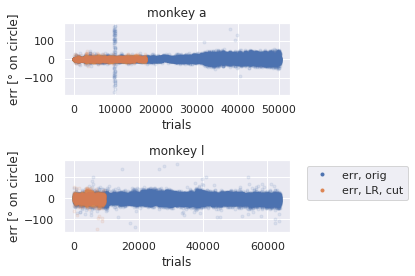

In [109]:
plt.figure()
for i,m in enumerate(['a', 'l']):
    plt.subplot(2,1,i+1)
    plt.plot(np.concatenate(err_corr[m]), '.', alpha=0.1,label='err, orig')
    plt.plot(np.concatenate(err_LR[m]), '.', alpha=0.1, label='err, LR, cut')
    plt.xlabel('trials')
    plt.ylabel('err [° on circle]')
    #plt.axvline(len(err_LR[m][0]), -180,180, color='grey', dashes=[1,3])
    #plt.axvline(len(err_LR[m][0])+len(err_LR[m][1]), -180,180, color='grey', dashes=[1,3])
    #plt.axvline(len(err_LR[m][0])+len(err_LR[m][1])+len(err_LR[m][2]), -180,180, color='grey', dashes=[1,3])
    #plt.axhline(0,0,65000, color='grey',  dashes=[10,10], linewidth=0.5)
    plt.title('monkey '+str(m))
    #plt.xlim([9500,10000])
    #plt.ylim([-50,50])
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
plt.tight_layout()
#plt.savefig('./Figures/CircularError_LR_mean_CompareOrig.png', dpi=100)
plt.show()

In [61]:
[err_LR[m][n][(delay_corr[m][sess_corr[m][n]] < np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR[m]))]


[array([-8.24723737e-01, -1.05866700e+00, -9.00429120e-01, -7.96404894e-01,
         7.66674682e-01,  7.33230826e-01, -3.04770479e-01, -1.59465265e+00,
        -9.02997258e-01, -1.35854281e+00, -2.51739406e-01, -2.18454804e-01,
        -1.69581707e+00, -2.04156733e+00,  3.85184534e-01, -4.43305087e-01,
        -1.97908678e+00, -5.37828728e-02, -1.86466254e+00, -4.04830303e-01,
         4.34072977e-01,  1.47690649e-01, -2.15911741e+00, -2.11994833e+00,
         1.12226017e+00, -2.17732986e+00,  1.89936321e+00, -2.23321332e+00,
         4.47274592e-01,  9.08200347e-01, -1.99443418e+00, -1.80427248e+00,
        -6.94156871e-01, -2.88126672e-01, -8.33611599e-01, -5.17098473e-02,
        -1.65583596e+00, -1.52184192e+00, -1.78279240e-01,  5.15598246e-01,
        -1.06565616e+00, -8.48854201e-01,  5.31938831e-01, -5.14325934e-01,
        -1.86953366e+00, -3.48168324e-01, -1.12362898e+00, -2.25485495e+00,
        -1.77861829e+00,  4.35138683e-01,  1.27416864e+00, -2.63053414e-01,
        -7.3

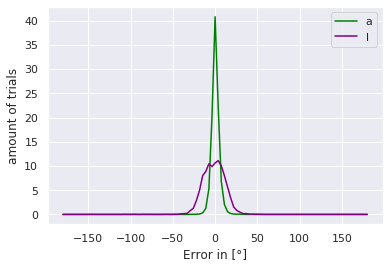

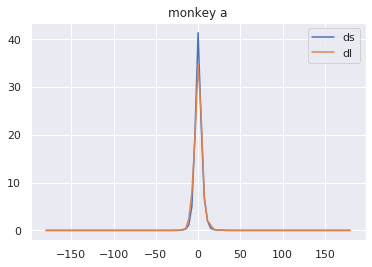

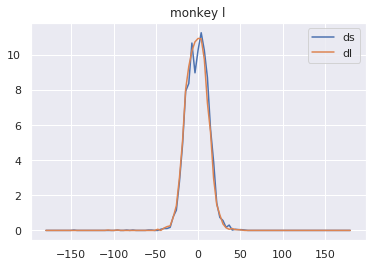

In [111]:
b_num = 100
b = np.linspace(-180,180,b_num)
histo_a=np.histogram(np.concatenate(err_LR['a']), bins=b)
histo_l=np.histogram(np.concatenate(err_LR['l']), bins=b)

plt.figure()
b=np.linspace(-180,180,b_num)
plt.plot(np.linspace(-180,180,b_num-1), histo_a[0]*100/len(np.concatenate(err_LR['a'])), label='a', color='green')
plt.plot(np.linspace(-180,180,b_num-1), histo_l[0]*100/len(np.concatenate(err_LR['l'])), label='l', color='purple')
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.legend()
plt.show()

################# DELAY DEPENDENCE
for i,m in enumerate(["a","l"]):
    ### all sessions
    #ds_LR = [err_LR[m][n][(delay_corr[m][n] < np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR[m]))]
    #dl_LR = [err_LR[m][n][(delay_corr[m][n] > np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR[m]))]

    ## only best sessions
    ds_LR = [err_LR[m][n][(delay_corr[m][sess_corr[m][n]] < np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR[m]))]
    dl_LR = [err_LR[m][n][(delay_corr[m][sess_corr[m][n]] > np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR[m]))]

    plt.figure()
    histo_ds=np.histogram(np.concatenate(ds_LR), bins=b)
    histo_dl=np.histogram(np.concatenate(dl_LR), bins=b)
    # plt.subplot(2,1,2)
    plt.plot(np.linspace(-180,180,b_num-1), histo_ds[0]*100/len(np.concatenate(ds_LR)), label='ds')
    plt.plot(np.linspace(-180,180,b_num-1), histo_dl[0]*100/len(np.concatenate(dl_LR)), label='dl')
    plt.title('monkey '+str(m))
    plt.legend()
    plt.show()

# Linear Regression seperated by sessions

In [118]:
# for each session seperately
from sklearn.linear_model import LinearRegression
X_delay_sess = {'a': ([],[],[],[]), 'l': ([],[],[],[])}
Targ_q_sess = {'a': ([],[]), 'l': ([],[])} 
y_Sac_sess = {'a': (([],[],[],[]), ([],[],[],[])), 'l': (([],[],[],[]), ([],[],[],[]))}
a_x_sess = {'a': ([],[],[],[]), 'l': ([],[],[],[])} 
a_y_sess = {'a': ([],[],[],[]), 'l': ([],[],[],[])} 
b_x_sess = {'a': ([],[],[],[]), 'l': ([],[],[],[])} 
b_y_sess = {'a': ([],[],[],[]), 'l': ([],[],[],[])} 
for i,m in enumerate(['a', 'l']):
    for n in range(len(df_LR[m]['delay'])):# for each session
        for qi, q in enumerate(['q1','q2','q3','q4']): # in each quadrant
            X_delay_sess[m][qi].append(np.c_[df_LR[m]['delay'][n][df_LR[m]['q'][n]==qi+1]])
            y_Sac_sess[m][0][qi].append(np.c_[df_LR[m]['sacX'][n][df_LR[m]['q'][n]==qi+1]])#_off
            y_Sac_sess[m][1][qi].append(np.c_[df_LR[m]['sacY'][n][df_LR[m]['q'][n]==qi+1]])#_off
            
            # fit LR
            reg_x_sess = LinearRegression().fit(X_delay_sess[m][qi][n], y_Sac_sess[m][0][qi][n])
            reg_y_sess = LinearRegression().fit(X_delay_sess[m][qi][n], y_Sac_sess[m][1][qi][n])

            # save params
            a_x_sess[m][qi].append(np.squeeze(reg_x_sess.coef_))
            b_x_sess[m][qi].append(reg_x_sess.intercept_)
            a_y_sess[m][qi].append(np.squeeze(reg_y_sess.coef_))
            b_y_sess[m][qi].append(reg_y_sess.intercept_)

            # bring targets in same format
            Targ_q_sess[m][0].append(np.concatenate(df_LR[m]['targX'])[np.concatenate(df_LR[m]['q'])==qi+1])
            Targ_q_sess[m][1].append(np.concatenate(df_LR[m]['targY'])[np.concatenate(df_LR[m]['q'])==qi+1])


#print(a_x_sess,b_x_sess)

#### determine shifting factor, shift respionses

In [119]:
#radius_LR = copy.deepcopy()#{'a':[], 'l':[]}# radius for each trial in each quadrant r[m][0]=q1, r[m][1]=q2,...
#radius_targ = {'a':[], 'l':[]}#
#Xi = {'a':[], 'l':[]}#
#Xi_mean = {'a':[], 'l':[]}#
#Sac_end_LR = {'a':([],[]), 'l':([],[])}
#Sac_end_LR_mean = {'a':([],[]), 'l':([],[])}


for m in ['a', 'l']:
    Xi_sess = copy.deepcopy(df_LR[m]['q'])
    Xi_mean_sess = copy.deepcopy(df_LR[m]['q'])
    for qi,q in enumerate(['q1','q2','q3','q4']):# in each quadrant
        # get radius from center of responses determined through LR: r = sqrt((x_i)²+(y_i)²)
        radius_LR_sess = [np.sqrt((a_x_sess[m][qi][n]*df_LR[m]['delay'][n][df_LR[m]['q'][n]==qi+1]+b_x_sess[m][qi][n])**2+(a_y_sess[m][qi][n]*df_LR[m]['delay'][n][df_LR[m]['q'][n]==qi+1]+b_y_sess[m][qi][n])**2) for n in range(len(df_LR[m]['q']))]
        # get target radius for each trial
        radius_targ_sess = [np.sqrt(df_LR[m]['targX'][n][df_LR[m]['q'][n]==qi+1]**2 + df_LR[m]['targY'][n][df_LR[m]['q'][n]==qi+1]**2) for n in range(len(df_LR[m]['q']))]
        for n in range(len(df_LR[m]['q'])):
            # determine shifting factor target_radius/radius_LR    
            Xi_sess[n][np.squeeze(np.where(df_LR[m]['q'][n]==qi+1))] = radius_targ_sess[n]/radius_LR_sess[n]
            Xi_mean_sess[n][np.squeeze(np.where(df_LR[m]['q'][n]==qi+1))] = np.median(radius_targ_sess[n])/radius_LR_sess[n]
    # determine new reponse coordinates: Xi*Sac x/y
    df_LR[m]['sacX_LR_sess'] = [df_LR[m]['sacX'][n]*Xi_sess[n] for n in range(len(df_LR[m]['q']))]#_off
    df_LR[m]['sacX_LR_mean_sess'] = [df_LR[m]['sacX'][n]*Xi_mean_sess[n] for n in range(len(df_LR[m]['q']))]#_off
    df_LR[m]['sacY_LR_sess'] = [df_LR[m]['sacY'][n]*Xi_sess[n] for n in range(len(df_LR[m]['q']))]#_off
    df_LR[m]['sacY_LR_mean_sess'] = [df_LR[m]['sacY'][n]*Xi_mean_sess[n] for n in range(len(df_LR[m]['q']))]#_off


#### determine best sessions

{'a': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 53, 54, 56, 58, 60], 'l': [0, 1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 19, 21, 24, 27, 29, 32, 33, 35, 36, 37, 38, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 62, 63, 64, 65]}


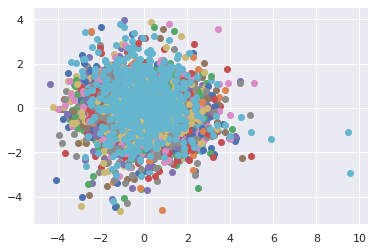

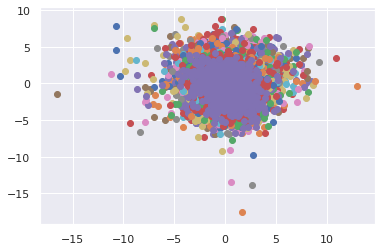

In [120]:
# only use sessions where std(err) is smaller a cut-off value in x/y
cut_std=0.04
sess_corr_sep = {'a': [], 'l': []}
for m in ['a', 'l']:
    ## session is chosen if error in x, error in y < cut_std
    ##seperate in x/y
    #sess_corr[m] = [n for n in range(len(df_LR[m]['sacX_LR_mean'])) if np.logical_and(abs(std(TargetAngle_corr[m][0][n]-df_LR[m]['sacX_LR_mean'][n]))<cut_std, abs(std(TargetAngle_corr[m][1][n]-df_LR[m]['sacY_LR_mean'][n]))<cut_std)]
    ##using radius of x,y
    sess_corr_sep[m] = [n for n in range(len(df_LR[m]['sacX_LR_mean_sess'])) if sem(np.sqrt((TargetAngle_corr[m][0][n]-df_LR[m]['sacX_LR_mean_sess'][n])**2 + (TargetAngle_corr[m][1][n]-df_LR[m]['sacY_LR_mean_sess'][n])**2))<cut_std]
    plt.figure()
    for n in sess_corr_sep[m]:#range(len(SacEnd_CoMass[m][0])):#
    #n=16
        plt.scatter(TargetAngle_corr[m][0][n]-df_LR[m]['sacX_LR_mean_sess'][n], TargetAngle_corr[m][1][n]-df_LR[m]['sacY_LR_mean_sess'][n], label=str(n))
        df_LR[m]['sacX_LR_mean_sess']
        #plt.legend()
print(sess_corr_sep)


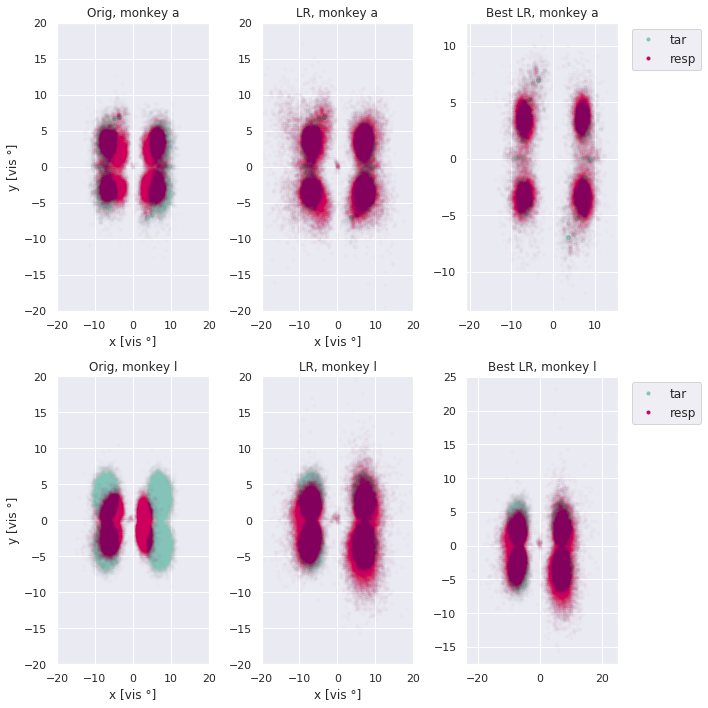

In [146]:
plt.figure(figsize=(10,10))
#plt.figure()
for i,m in enumerate(["a","l"]): 
    plt.subplots_adjust(wspace=0.3, hspace=0.7)
    plt.subplot(2,3,3*i+1)
    xVal=np.concatenate(TargetAngle_cut[m][0])
    yVal=np.concatenate(TargetAngle_cut[m][1])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#83C3B8', label = 'target')
    xVal=np.concatenate(SacEnd_cut[m][0])
    yVal=np.concatenate(SacEnd_cut[m][1])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#CC005C', label = 'saccade')
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.title('Orig, monkey '+str(m))
    plt.xlabel('x [vis °]')
    plt.ylabel('y [vis °]')
        
    plt.subplot(2,3,3*i+2)
    xVal=np.concatenate(TargetAngle_cut[m][0])
    yVal=np.concatenate(TargetAngle_cut[m][1])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#83C3B8', label = 'target')
    xVal=np.concatenate(df_LR[m]['sacX_LR_mean_sess'])
    yVal=np.concatenate(df_LR[m]['sacY_LR_mean_sess'])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#CC005C', label = 'saccade')
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.title('LR, monkey '+str(m))
    #leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #for lh in leg.legendHandles: 
    #    lh._legmarker.set_alpha(1)
    plt.xlabel('x [vis °]')
            
    plt.subplot(2,3,3*i+3)
    xVal=np.concatenate([TargetAngle_cut[m][0][i] for i in sess_corr_sep[m]])
    yVal=np.concatenate([TargetAngle_cut[m][1][i] for i in sess_corr_sep[m]])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#83C3B8', label = 'tar')
    xVal=np.concatenate([df_LR[m]['sacX_LR_mean_sess'][i] for i in sess_corr_sep[m]])
    yVal=np.concatenate([df_LR[m]['sacY_LR_mean_sess'][i] for i in sess_corr_sep[m]])
    #xVal=np.concatenate(Sac_end_LR[m][0])
    #yVal=np.concatenate(Sac_end_LR[m][1])
    plt.plot(xVal,yVal,".",alpha=0.01, color='#CC005C',label = 'resp')
    #plt.xlim([-20,20])
    #plt.ylim([-20,20])
    plt.title('Best LR, monkey '+str(m))
    ##leg = plt.legend()
    ##for lh in leg.legendHandles: 
    ##    lh._legmarker.set_alpha(1)
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)
plt.tight_layout()
#plt.savefig('../Figures/LinearRegressed_TargetResponse_best.png', dpi=100)
plt.show()


#### delay dependence

xerr vs delay, a : SpearmanrResult(correlation=0.3595844245074662, pvalue=0.0)
yerr vs delay, a : SpearmanrResult(correlation=0.356070647731905, pvalue=0.0)
xerr²+yerr², a : SpearmanrResult(correlation=0.45898744154753157, pvalue=0.0)


<Figure size 360x360 with 0 Axes>

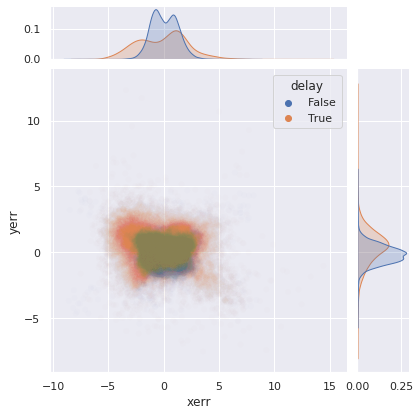

xerr vs delay, l : SpearmanrResult(correlation=0.0032046013476594143, pvalue=0.4179349749012483)
yerr vs delay, l : SpearmanrResult(correlation=-0.015486648969792263, pvalue=9.05175073949292e-05)
xerr²+yerr², l : SpearmanrResult(correlation=-0.010031665704127248, pvalue=0.01122212323333678)


<Figure size 360x360 with 0 Axes>

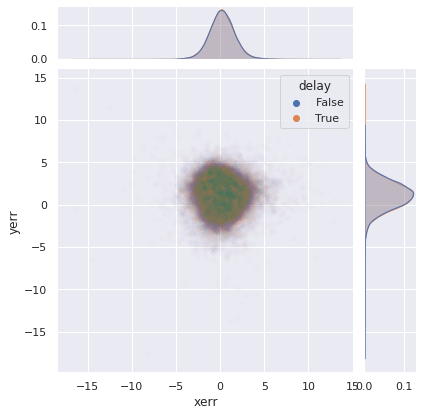

In [152]:
cut_short_LR_sess = {'a':[], 'l':[]}
xerr_mean_sess = {'a':[], 'l':[]}
yerr_mean_sess = {'a':[], 'l':[]}
for i,m in enumerate(['a','l']):
    #cut_short_LR_sess[m] = (np.concatenate(df_LR[m]['delay'])>np.mean(np.concatenate(df_LR[m]['delay'])))
    cut_short_LR_sess[m] = (np.concatenate(df_LR[m]['delay'])>np.mean(np.concatenate(df_LR[m]['delay'])))# [i] for i in sess_corr_sep[m]]

    #xerr_mean_sess[m] = np.concatenate(df_LR[m]['targX']) - np.concatenate(df_LR[m]['sacX_LR_mean_sess'])
    #yerr_mean_sess[m] = np.concatenate(df_LR[m]['targY']) - np.concatenate(df_LR[m]['sacY_LR_mean_sess'])
    xerr_mean_sess[m] = np.concatenate(df_LR[m]['targX'])- np.concatenate(df_LR[m]['sacX_LR_mean'])# [i] for i in sess_corr_sep[m]]
    yerr_mean_sess[m] = np.concatenate(df_LR[m]['targY']) - np.concatenate(df_LR[m]['sacY_LR_mean'])
    
    #print('xerr vs delay, '+str(m)+' : '+str(spearmanr((xerr_mean_sess[m])**2, np.concatenate(df_LR[m]['delay']))))
    #print('yerr vs delay, '+str(m)+' : '+str(spearmanr((yerr_mean_sess[m])**2, np.concatenate(df_LR[m]['delay']))))
    print('xerr vs delay, '+str(m)+' : '+str(spearmanr(abs(xerr_mean_sess[m]), np.concatenate(df_LR[m]['delay']))))# [i] for i in sess_corr_sep[m]]
    print('yerr vs delay, '+str(m)+' : '+str(spearmanr(abs(yerr_mean_sess[m]), np.concatenate(df_LR[m]['delay']))))
    print('xerr²+yerr², '+str(m)+' : '+str(spearmanr((xerr_mean_sess[m])**2+(yerr_mean_sess[m])**2, np.concatenate(df_LR[m]['delay']))))

    xy = {'xerr': xerr_mean_sess[m], 'yerr': yerr_mean_sess[m], 'delay': cut_short_LR_sess[m]}
    df_xy = pd.DataFrame(xy)

    plt.figure(figsize=(5,5))
    sns.set_theme()
    sns.jointplot(data=df_xy, x="xerr", y="yerr", hue="delay", marginal_ticks=True, alpha=0.01)# short delay=False, long delay=True
    #plt.savefig('../Figures/Behavior/LinRegSess_delaydep_A.png', dpi=100)
    plt.show()


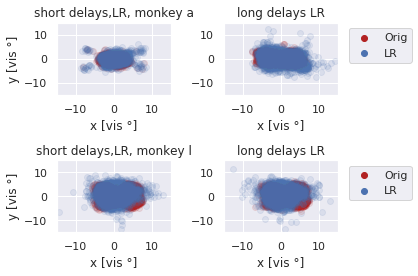

In [153]:
plt.figure()
for i,m in enumerate(['a','l']):
    # plot delay dependence side by side
    subplots_adjust(wspace=0.3, hspace=0.7)
    plt.subplot(2,2,2*i+1)
    plt.scatter((xerr_cut[m][np.concatenate(cut_short[m])==False]), yerr_cut[m][(np.concatenate(cut_short[m])==False)], color='firebrick', alpha=0.1)
    plt.scatter((xerr_mean_sess[m][cut_short_LR_sess[m]==False]), yerr_mean_sess[m][(cut_short_LR_sess[m])==False], alpha=0.1)
    plt.title('short delays,LR, monkey '+str(m))
    plt.xlabel('x [vis °]')
    plt.ylabel('y [vis °]')
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.subplot(2,2,2*i+2)
    plt.scatter((xerr_cut[m][np.concatenate(cut_short[m])]), yerr_cut[m][(np.concatenate(cut_short[m]))], color='firebrick', alpha=0.1, label='Orig')
    plt.scatter(xerr_mean_sess[m][cut_short_LR_sess[m]], yerr_mean_sess[m][cut_short_LR_sess[m]], alpha=0.1, label='LR')
    plt.title('long delays LR')
    plt.xlabel('x [vis °]')
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
plt.tight_layout()
#plt.savefig('./Figures/Error_LR_mean_CompareOrig_centered.png', dpi=300)
#plt.savefig('./Figures/Error_LR_mean_centered.png', dpi=300)
plt.show()

#### check single trials

trials in session: 303


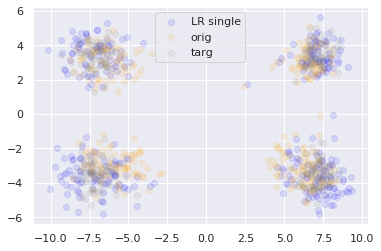

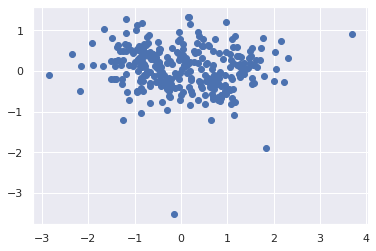

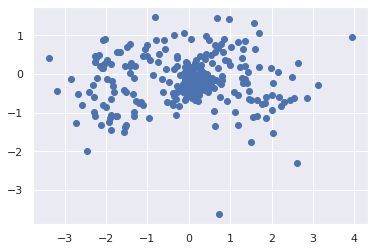

In [512]:
m='a'
n=34  # a:3,
print('trials in session: '+str(len(df_LR[m]['targX'][n])))
plt.figure()
plt.scatter(df_LR[m]['sacX_LR_mean_sess'][n],df_LR[m]['sacY_LR_mean_sess'][n], color='blue',alpha=0.1, label='LR single')
plt.scatter(df_LR[m]['sacX_off'][n], df_LR[m]['sacY_off'][n], color='orange',alpha=0.1, label='orig')
plt.scatter(df_LR[m]['targX'][n], df_LR[m]['targY'][n], color='grey',alpha=0.1, label='targ')
plt.legend()
plt.show()

plt.figure()
plt.scatter(df_LR[m]['targX'][n] - df_LR[m]['sacX_LR_mean_sess'][n],df_LR[m]['targY'][n] - df_LR[m]['sacY_LR_mean_sess'][n]) 
plt.show()

plt.figure()
plt.scatter(df_LR[m]['targX'][n] - df_LR[m]['sacX'][n],df_LR[m]['targY'][n] - df_LR[m]['sacY'][n]) 
plt.show()

### convert to angle on deg LR single session

In [177]:
df_LR['a']['targX'][0]*np.pi/180

array([ 0.15707905, -0.13919245, -0.13032224,  0.14190371, -0.14274407,
       -0.13623965, -0.12128671,  0.08576237,  0.13470339,  0.13256431,
       -0.12859585,  0.12781734,  0.13616854,  0.14808036, -0.12626832,
       -0.10909272,  0.09294738, -0.16010858,  0.07901411, -0.13997577,
       -0.15443014, -0.09260582,  0.16622143,  0.12947769, -0.09184072,
        0.09950252, -0.16254293,  0.16632023, -0.12694749, -0.14595801,
        0.11896288,  0.12116656,  0.0996041 ,  0.15912618, -0.13490871,
       -0.14791176,  0.12244329,  0.09954213, -0.16424167, -0.12917204,
        0.12149372,  0.09075584, -0.12834867,  0.1175683 ,  0.12417535,
       -0.13479012,  0.12932595,  0.10257705,  0.14129137, -0.16299915,
       -0.12950125,  0.08901668,  0.12427813, -0.13066664,  0.09588245,
        0.1155992 ,  0.16748841, -0.13632137,  0.13443728, -0.10493603,
        0.11292273,  0.10899051, -0.14623583, -0.09855739,  0.16539406,
       -0.13640952,  0.1421717 ,  0.13568991,  0.14405068,  0.07

In [192]:
m='a'
len(convert_visdeg2deg2([i*np.pi/180 for i in df_LR[m]['sacX_LR_mean_sess']], [i*np.pi/180 for i in df_LR[m]['sacY_LR_mean_sess']], screen_len))

94


94

In [194]:
alphaTrial_LR_sess = {'a': [], 'l': []}
alphaResponse_LR_sess = {'a': [], 'l': []}
err_LR_sess = {'a': [], 'l': []}

for m in ['a','l']:
    alphaTrial_LR_sess[m] = convert_visdeg2deg2([i * np.pi/180 for i in df_LR[m]['targX']], [i * np.pi/180 for i in df_LR[m]['targY']], screen_len)#
    #alphaTrial_LR_sess[m] = convert_visdeg2deg2([[df_LR[m]['targX'][s][idx]*np.pi/180 for idx in range(len(df_LR[m]['targX'][s]))] for s in sess_corr_sep[m]], [[df_LR[m]['targY'][s][idx]*np.pi/180 for idx in range(len(df_LR[m]['targY'][s]))] for s in sess_corr_sep[m]], screen_len)#

    alphaResponse_LR_sess[m] = convert_visdeg2deg2([i*np.pi/180 for i in df_LR[m]['sacX_LR_mean_sess']], [i*np.pi/180 for i in df_LR[m]['sacY_LR_mean_sess']], screen_len)
    #alphaResponse_LR_sess[m] = convert_visdeg2deg2([[df_LR[m]['sacX_LR_mean_sess'][s][idx]*np.pi/180 for idx in range(len(df_LR[m]['sacX_LR_mean_sess'][s]))] for s in sess_corr_sep[m]], [[df_LR[m]['sacY_LR_mean_sess'][s][idx]*np.pi/180 for idx in range(len(df_LR[m]['sacY_LR_mean_sess'][s]))] for s in sess_corr_sep[m]], screen_len)#

    err_LR_sess[m] = [circdist(alphaTrial_LR_sess[m][i]*np.pi/180, alphaResponse_LR_sess[m][i]*np.pi/180) for i in range(len(alphaTrial_LR_sess[m]))]
    #err_LR_sess[m] = [i*180/np.pi for i in err_LR_sess[m]]
    # delay lengths



94
94
66
66


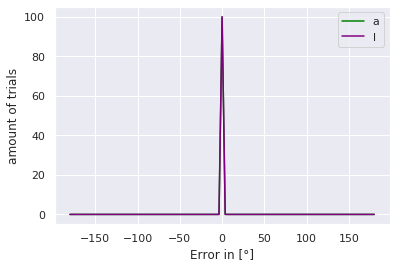

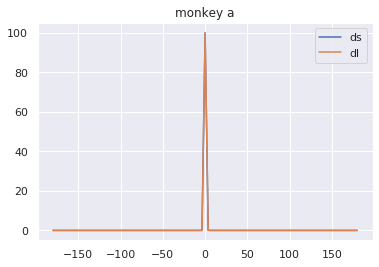

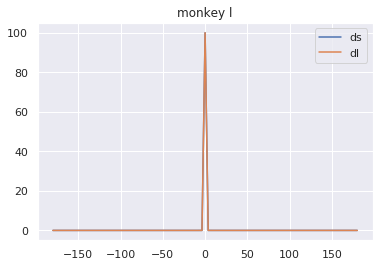

In [196]:
b_num = 100
b = np.linspace(-180,180,b_num)
histo_a=np.histogram(np.concatenate(err_LR_sess['a']), bins=b)
histo_l=np.histogram(np.concatenate(err_LR_sess['l']), bins=b)

plt.figure()
b=np.linspace(-180,180,b_num)
plt.plot(np.linspace(-180,180,b_num-1), histo_a[0]*100/len(np.concatenate(err_LR_sess['a'])), label='a', color='green')
plt.plot(np.linspace(-180,180,b_num-1), histo_l[0]*100/len(np.concatenate(err_LR_sess['l'])), label='l', color='purple')
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.legend()
plt.show()


################# DELAY DEPENDENCE
for i,m in enumerate(["a","l"]):
    ### all trials
    ds_LR = [err_LR_sess[m][n][(delay_corr[m][n] < np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR_sess[m]))]
    dl_LR = [err_LR_sess[m][n][(delay_corr[m][n] > np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR_sess[m]))]

    ### only best trials
    #ds_LR = [err_LR_sess[m][n][(delay_corr[m][sess_corr_sep[m][n]] < np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR_sess[m]))]
    #dl_LR = [err_LR_sess[m][n][(delay_corr[m][sess_corr_sep[m][n]] > np.mean(np.concatenate(delay_corr[m])))] for n in range(len(err_LR_sess[m]))]

    plt.figure()
    histo_ds=np.histogram(np.concatenate(ds_LR), bins=b)
    histo_dl=np.histogram(np.concatenate(dl_LR), bins=b)
    # plt.subplot(2,1,2)
    plt.plot(np.linspace(-180,180,b_num-1), histo_ds[0]*100/len(np.concatenate(ds_LR)), label='ds')
    plt.plot(np.linspace(-180,180,b_num-1), histo_dl[0]*100/len(np.concatenate(dl_LR)), label='dl')
    plt.title('monkey '+str(m))
    plt.legend()
    plt.show()

# Serial Dependence

#### create dataframe

In [197]:
len(sess_corr_sep['a'])

50

In [162]:
len(alphaResponse_LR_sess['a'])

50

In [264]:
data_sd = {"a": {"target1": [],"target2": [],"response1": [],"response2": []}, "l": {"target1": [],"target2": [],"response1": [],"response2": []}}
data_sd_future = {"a": {"target1": [],"target2": [],"response1": [],"response2": []}, "l": {"target1": [],"target2": [],"response1": [],"response2": []}}
idx_help = {'a': np.concatenate(full_idx['a']), 'l' : np.concatenate(full_idx['l'])}

### LINEAR REGRESSION, SEPERATE SESSIONS, BEST
#idx_corr_sess = {'a': [idx_corr['a'][i] for i in sess_corr_sep['a']], 'l': [idx_corr['l'][i] for i in sess_corr_sep['l']]}
### LINEAR REGRESSION, ALL SESSIONS COMBINED, BEST
#idx_corr_sess = {'a': [idx_corr['a'][i] for i in sess_corr['a']], 'l': [idx_corr['l'][i] for i in sess_corr['l']]}
### CENTER OF MASS, BEST
#idx_corr_sess = {'a': [idx_corr['a'][i] for i in sess['a']], 'l': [idx_corr['l'][i] for i in sess['l']]}

for m in ['a','l']: # for each monkey
    ### LINEAR REGRESSION, SEPERATE SESSIONS
    for n in range(len(alphaTrial_LR[m])):# for each session
        idx_sd = [idx for idx in range(len(alphaTrial_LR_sess[m][n])-1) if idx_corr[m][n][idx]+1 == idx_corr[m][n][idx+1]]# idx_corr_sess
        data_sd[m]['target1'].append([alphaTrial_LR_sess[m][n][i]*np.pi/180 for i in idx_sd])
        data_sd[m]['target2'].append([alphaTrial_LR_sess[m][n][i+1]*np.pi/180 for i in idx_sd])
        data_sd[m]['response1'].append([alphaResponse_LR_sess[m][n][i]*np.pi/180 for i in idx_sd])
        data_sd[m]['response2'].append([alphaResponse_LR_sess[m][n][i+1]*np.pi/180 for i in idx_sd])
        data_sd_future[m]['target1'].append([alphaTrial_LR_sess[m][n][i+1]*np.pi/180 for i in idx_sd])
        data_sd_future[m]['target2'].append([alphaTrial_LR_sess[m][n][i]*np.pi/180 for i in idx_sd])
        data_sd_future[m]['response1'].append([alphaResponse_LR_sess[m][n][i+1]*np.pi/180 for i in idx_sd])
        data_sd_future[m]['response2'].append([alphaResponse_LR_sess[m][n][i]*np.pi/180 for i in idx_sd])
        
    ### LINEAR REGRESSION, ALL SESSIONS COMBINED
    #for n in range(len(alphaTrial_LR[m])):# for each session
    #    idx_sd = [idx for idx in range(len(alphaTrial_LR[m][n])-1) if idx_corr_sess[m][n][idx]+1 == idx_corr_sess[m][n][idx+1]]
    #    data_sd[m]['target1'].append([alphaTrial_LR[m][n][i]*np.pi/180 for i in idx_sd])
    #    data_sd[m]['target2'].append([alphaTrial_LR[m][n][i+1]*np.pi/180 for i in idx_sd])
    #    data_sd[m]['response1'].append([alphaResponse_LR[m][n][i]*np.pi/180 for i in idx_sd])
    #    data_sd[m]['response2'].append([alphaResponse_LR[m][n][i+1]*np.pi/180 for i in idx_sd])
    #    data_sd_future[m]['target1'].append([alphaTrial_LR[m][n][i+1]*np.pi/180 for i in idx_sd])
    #    data_sd_future[m]['target2'].append([alphaTrial_LR[m][n][i]*np.pi/180 for i in idx_sd])
    #    data_sd_future[m]['response1'].append([alphaResponse_LR[m][n][i+1]*np.pi/180 for i in idx_sd])
    #    data_sd_future[m]['response2'].append([alphaResponse_LR[m][n][i]*np.pi/180 for i in idx_sd])
     
    ### CENTER OF MASS
    #for n in range(len(alphaTrial_CoMass[m])): #sess[m]:#
    #    alphaTrial_CoMass_cut = alphaTrial_CoMass[m][n][abs(err_CoMass[m][n])<cut_off]
    #    alphaResponse_CoMass_cut = alphaResponse_CoMass[m][n][abs(err_CoMass[m][n])<cut_off]
    #    idx_CoMass_cut = idx_corr_sess[m][n][abs(err_CoMass[m][n])<cut_off]
    #    idx_sd = [idx for idx in range(len(alphaTrial_CoMass_cut)-1) if idx_CoMass_cut[idx]+1 == idx_CoMass_cut[idx+1]]
    #    data_sd[m]['target1'].append([alphaTrial_CoMass_cut[i]*np.pi/180 for i in idx_sd])
    #    data_sd[m]['target2'].append([alphaTrial_CoMass_cut[i+1]*np.pi/180 for i in idx_sd])
    #    data_sd[m]['response1'].append([alphaResponse_CoMass_cut[i]*np.pi/180 for i in idx_sd])
    #    data_sd[m]['response2'].append([alphaResponse_CoMass_cut[i+1]*np.pi/180 for i in idx_sd])
    #    data_sd_future[m]['target1'].append([alphaTrial_CoMass_cut[i+1]*np.pi/180 for i in idx_sd])
    #    data_sd_future[m]['target2'].append([alphaTrial_CoMass_cut[i]*np.pi/180 for i in idx_sd])
    #    data_sd_future[m]['response1'].append([alphaResponse_CoMass_cut[i+1]*np.pi/180 for i in idx_sd])
    #    data_sd_future[m]['response2'].append([alphaResponse_CoMass_cut[i]*np.pi/180 for i in idx_sd])
        
    ### NO CORRECTION (ONLY GOODTRIALS)
        #idx_sd = [idx for idx in range(len(alphaTrial_cut[m][n])-1) if idx_cut[m][n][idx]+1 == idx_cut[m][n][idx+1]]
        #data_sd[m]['target1'].append([alphaTrial_cut[m][n][i]*np.pi/180 for i in idx_sd])
        #data_sd[m]['target2'].append([alphaTrial_cut[m][n][i+1]*np.pi/180 for i in idx_sd])
        #data_sd[m]['response1'].append([alphaResponse_cut[m][n][i]*np.pi/180 for i in idx_sd])
        #data_sd[m]['response2'].append([alphaResponse_cut[m][n][i+1]*np.pi/180 for i in idx_sd])
        #data_sd_future[m]['target1'].append([alphaTrial_cut[m][n][i+1]*np.pi/180 for i in idx_sd])
        #data_sd_future[m]['target2'].append([alphaTrial_cut[m][n][i]*np.pi/180 for i in idx_sd])
        #data_sd_future[m]['response1'].append([alphaResponse_cut[m][n][i+1]*np.pi/180 for i in idx_sd])
        #data_sd_future[m]['response2'].append([alphaResponse_cut[m][n][i]*np.pi/180 for i in idx_sd])


#### calculate moving average of serial bias

In [271]:
## moving average fit for data
w1 = np.pi/3
w2 = np.pi/30
    
sd_avg, sd_avg_single, rel_loc_avg, sd_std, sd_std_single, err, rel_loc,\
    sd_avg_both, sd_avg_both_single, rel_both, sd_std_both, sd_std_both_single, err_both = calc_errorcurve2(data_sd, w1, w2)

sd_avg_future, sd_avg_single_future, rel_loc_avg_future, sd_std_future, sd_std_single_future, err_future, rel_loc_future,\
    sd_avg_both_future, sd_avg_both_single_future, rel_both_future, sd_std_both_future, sd_std_both_single_future, err_both_future = calc_errorcurve2(data_sd_future, w1, w2)

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


#### DoG fit

In [272]:
# DoG fit for data
def test_func(x,a,w):
    return a * w * x * (np.sqrt(2)/np.exp(-0.5)) * np.exp(-(w*x)**2)

# create x/y values
x_data_a = np.concatenate(rel_loc['a'])*360/(2*np.pi)#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
y_data_a = np.concatenate(err['a'])*360/(2*np.pi)#df_sb.sort_values('rel_loc')['err']#
x_data_l = np.concatenate(rel_loc['l'])*360/(2*np.pi)#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
y_data_l = np.concatenate(err['l'])*360/(2*np.pi)#df_sb.sort_values('rel_loc')['err']#
x_data_both = np.concatenate(rel_both)*360/(2*np.pi)
y_data_both = np.concatenate(err_both)*360/(2*np.pi)

x_data_a_future = np.concatenate(rel_loc_future['a'])*360/(2*np.pi)#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
y_data_a_future = np.concatenate(err_future['a'])*360/(2*np.pi)#df_sb.sort_values('rel_loc')['err']#
x_data_l_future = np.concatenate(rel_loc_future['l'])*360/(2*np.pi)#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
y_data_l_future = np.concatenate(err_future['l'])*360/(2*np.pi)#df_sb.sort_values('rel_loc')['err']#
x_data_both_future = np.concatenate(rel_both_future)*360/(2*np.pi)
y_data_both_future = np.concatenate(err_both_future)*360/(2*np.pi)

# fit DoG
params_a, param_cov_a = curve_fit(test_func, x_data_a, y_data_a, p0=[1, 0.1])#
params_l, param_cov_l = curve_fit(test_func, x_data_l, y_data_l, p0=[3, 0.1])
params_both, param_cov_both = curve_fit(test_func, x_data_both, y_data_both, p0=[3, 0.1])

params_a_future, param_cov_a_future = curve_fit(test_func, x_data_a, y_data_a, p0=[1, 0.1])#
params_l_future, param_cov_l_future = curve_fit(test_func, x_data_l, y_data_l, p0=[3, 0.1])
params_both_future, param_cov_both_future = curve_fit(test_func, x_data_both, y_data_both, p0=[3, 0.1])

### Plot SB

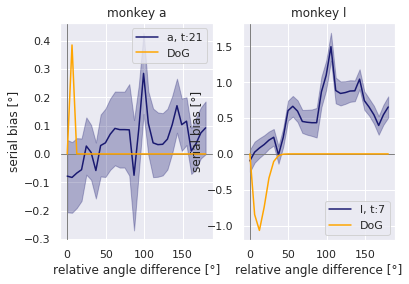

In [274]:
###  monkey A   ###
plt.figure()
plt.subplot(121)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
#plt.scatter(x_data_a, y_data_a, color='k', alpha=0.1)
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg['a']*360/(2*np.pi)-0.5*sd_std['a']*180/np.pi, sd_avg['a']*360/(2*np.pi)+0.5*sd_std['a']*180/np.pi, alpha=0.3, color = 'midnightblue')
plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg['a']*360/(2*np.pi), color = 'midnightblue', label='a, t:'+str(len(err['a'])))
#plt.scatter(rel_loc['a']*360/(2*np.pi), err['a']*360/(2*np.pi))
#plt.scatter(rel_loc['l']*360/(2*np.pi), err['l']*360/(2*np.pi))
# plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg['l']*360/(2*np.pi)-0.5*sd_std['l']*180/np.pi, sd_avg['l']*360/(2*np.pi)+0.5*sd_std['l']*180/np.pi, alpha=0.3, color = 'darkred')
# plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg['l']*360/(2*np.pi), color = 'darkred', label='l, t:'+str(len(err['l'])))
# plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg_full*360/(2*np.pi)-0.5*sd_std_full*180/np.pi, sd_avg_full*360/(2*np.pi)+0.5*sd_std_full*180/np.pi, alpha=0.3, color = 'gray')
# plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg_full*360/(2*np.pi), color = 'gray', label='a+l, t:'+str(len(err_full)))
plt.plot(rel_loc_avg*360/(2*np.pi), test_func(rel_loc_avg*360/(2*np.pi), params_a[0], params_a[1]), label='DoG',color='orange')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.title('monkey a')
plt.legend()
#plt.savefig('/home/melanie/Schreibtisch/IDIBAPS/PhD/Code/HartHuk/Figures/SerialBias_a.png', dpi=300)

###  monkey L   ###
plt.subplot(122)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
#plt.scatter(x_data_l, y_data_l, color='k', alpha=0.1)
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg['l']*360/(2*np.pi)-0.5*sd_std['l']*180/np.pi, sd_avg['l']*360/(2*np.pi)+0.5*sd_std['l']*180/np.pi, alpha=0.3, color = 'midnightblue')
plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg['l']*360/(2*np.pi), color = 'midnightblue', label='l, t:'+str(len(err['l'])))
plt.plot(rel_loc_avg*360/(2*np.pi), test_func(rel_loc_avg*360/(2*np.pi), params_l[0], params_l[1]), label='DoG',color='orange')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.title('monkey l')
plt.legend()
# plt.savefig('/home/melanie/Schreibtisch/IDIBAPS/PhD/Code/HartHuk/Figures/SerialBias_l.png', dpi=300)
plt.show()

#### plot single trial serial bias

<Figure size 432x288 with 0 Axes>

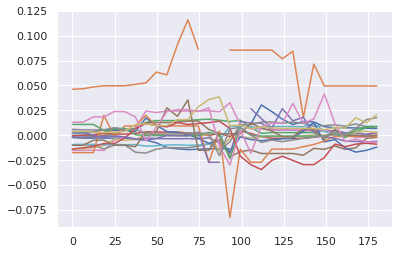

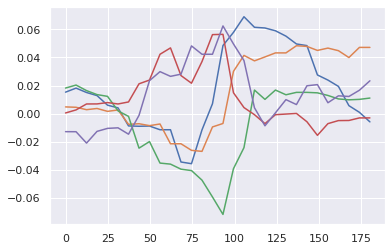

In [275]:
# all single trial moving averages
plt.figure()
#plt.scatter(rel_loc['a'][0]*180/np.pi, err['a'][0]*180/np.pi, color='k', alpha=0.1)
for m in ['a', 'l']:
    plt.figure()
    for i in range(len(sd_avg_single[m])-2):
        plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg_single[m][i], label=str(i))
    #plt.legend()
    plt.show()

### Plot SD future

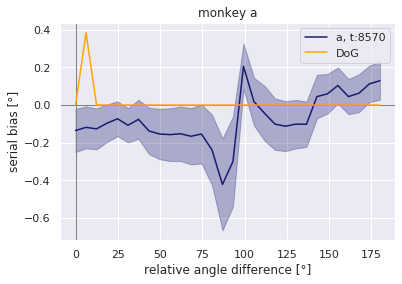

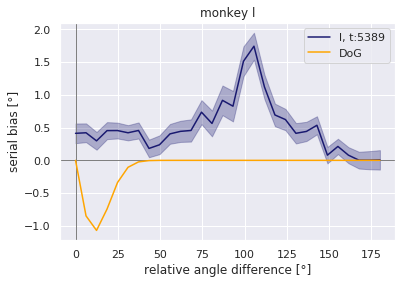

In [276]:
###  monkey A   ###
plt.figure()
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
#plt.scatter(x_data_a_future, y_data_a_future, color='k', alpha=0.1)
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg_future['a']*360/(2*np.pi)-0.5*sd_std_future['a']*180/np.pi, sd_avg_future['a']*360/(2*np.pi)+0.5*sd_std_future['a']*180/np.pi, alpha=0.3, color = 'midnightblue')
plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg_future['a']*360/(2*np.pi), color = 'midnightblue', label='a, t:'+str(len(np.concatenate(err_future['a']))))
plt.plot(rel_loc_avg*360/(2*np.pi), test_func(rel_loc_avg*360/(2*np.pi), params_a_future[0], params_a_future[1]), label='DoG',color='orange')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.title('monkey a')
plt.legend()
plt.show()

###  monkey L   ###
plt.figure()
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
#plt.scatter(x_data_l_future, y_data_l_future, color='k', alpha=0.1)
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg_future['l']*360/(2*np.pi)-0.5*sd_std_future['l']*180/np.pi, sd_avg_future['l']*360/(2*np.pi)+0.5*sd_std_future['l']*180/np.pi, alpha=0.3, color = 'midnightblue')
plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg_future['l']*360/(2*np.pi), color = 'midnightblue', label='l, t:'+str(len(np.concatenate(err_future['l']))))
plt.plot(rel_loc_avg*360/(2*np.pi), test_func(rel_loc_avg*360/(2*np.pi), params_l_future[0], params_l_future[1]), label='DoG',color='orange')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.title('monkey l')
plt.legend()
plt.show()

### Compare SB, future SB

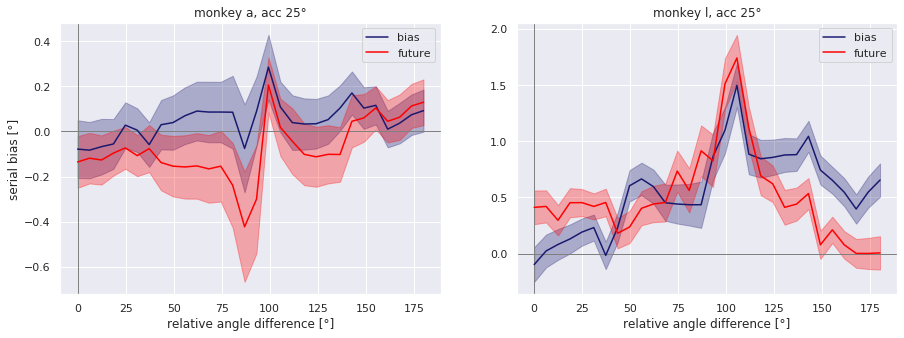

In [281]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg['a']*360/(2*np.pi), color = 'midnightblue', label='bias')
plt.plot(rel_loc_avg_future*360/(2*np.pi), sd_avg_future['a']*360/(2*np.pi), color = 'red', label='future')
#plt.plot(rel_loc_avg_future*360/(2*np.pi), (sd_avg['a']-sd_avg_future['a'])*360/(2*np.pi), color = 'orange', label='diff')
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg['a']*360/(2*np.pi)-0.5*sd_std['a']*180/np.pi, sd_avg['a']*360/(2*np.pi)+0.5*sd_std['a']*180/np.pi, alpha=0.3, color = 'midnightblue')
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg_future['a']*360/(2*np.pi)-0.5*sd_std_future['a']*180/np.pi, sd_avg_future['a']*360/(2*np.pi)+0.5*sd_std_future['a']*180/np.pi, alpha=0.3, color = 'red')
plt.title('monkey a, acc '+str(cut_off)+'°')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.legend()
plt.subplot(122)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg['l']*360/(2*np.pi), color = 'midnightblue', label='bias')
plt.plot(rel_loc_avg_future*360/(2*np.pi), sd_avg_future['l']*360/(2*np.pi), color = 'red', label='future')
#plt.plot(rel_loc_avg_future*360/(2*np.pi), (sd_avg['l']-sd_avg_future['l'])*360/(2*np.pi), color = 'orange', label='diff')
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg['l']*360/(2*np.pi)-0.5*sd_std['l']*180/np.pi, sd_avg['l']*360/(2*np.pi)+0.5*sd_std['l']*180/np.pi, alpha=0.3, color = 'midnightblue')
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg_future['l']*360/(2*np.pi)-0.5*sd_std_future['l']*180/np.pi, sd_avg_future['l']*360/(2*np.pi)+0.5*sd_std_future['l']*180/np.pi, alpha=0.3, color = 'red')
plt.title('monkey l, acc '+str(cut_off)+'°')
plt.xlabel('relative angle difference [°]')
plt.legend()
#plt.savefig('../Figures/Behavior/BiasVSFuture.png', dpi=100)
plt.show()

In [213]:
rel_loc_avg

array([-3.14159265, -3.03509799, -2.92860332, -2.82210865, -2.71561399,
       -2.60911932, -2.50262466, -2.39612999, -2.28963532, -2.18314066,
       -2.07664599, -1.97015133, -1.86365666, -1.75716199, -1.65066733,
       -1.54417266, -1.43767799, -1.33118333, -1.22468866, -1.118194  ,
       -1.01169933, -0.90520466, -0.79871   , -0.69221533, -0.58572066,
       -0.479226  , -0.37273133, -0.26623667, -0.159742  , -0.05324733,
        0.05324733,  0.159742  ,  0.26623667,  0.37273133,  0.479226  ,
        0.58572066,  0.69221533,  0.79871   ,  0.90520466,  1.01169933,
        1.118194  ,  1.22468866,  1.33118333,  1.43767799,  1.54417266,
        1.65066733,  1.75716199,  1.86365666,  1.97015133,  2.07664599,
        2.18314066,  2.28963532,  2.39612999,  2.50262466,  2.60911932,
        2.71561399,  2.82210865,  2.92860332,  3.03509799,  3.14159265])

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg['a']*360/(2*np.pi), color = 'midnightblue', label='bias')
plt.plot(rel_loc_avg_future*360/(2*np.pi), sd_avg_future['a']*360/(2*np.pi), color = 'red', label='future')
#plt.plot(rel_loc_avg_future*360/(2*np.pi), (sd_avg['a']-sd_avg_future['a'])*360/(2*np.pi), color = 'orange', label='diff')
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg['a']*360/(2*np.pi)-0.5*sd_std['a']*180/np.pi, sd_avg['a']*360/(2*np.pi)+0.5*sd_std['a']*180/np.pi, alpha=0.3, color = 'midnightblue')
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg_future['a']*360/(2*np.pi)-0.5*sd_std_future['a']*180/np.pi, sd_avg_future['a']*360/(2*np.pi)+0.5*sd_std_future['a']*180/np.pi, alpha=0.3, color = 'red')
plt.title('monkey a, acc '+str(cut_off)+'°')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.legend()
plt.subplot(122)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
plt.plot(rel_loc_avg*360/(2*np.pi), sd_avg['l']*360/(2*np.pi), color = 'midnightblue', label='bias')
plt.plot(rel_loc_avg_future*360/(2*np.pi), sd_avg_future['l']*360/(2*np.pi), color = 'red', label='future')
#plt.plot(rel_loc_avg_future*360/(2*np.pi), (sd_avg['l']-sd_avg_future['l'])*360/(2*np.pi), color = 'orange', label='diff')
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg['l']*360/(2*np.pi)-0.5*sd_std['l']*180/np.pi, sd_avg['l']*360/(2*np.pi)+0.5*sd_std['l']*180/np.pi, alpha=0.3, color = 'midnightblue')
plt.fill_between(rel_loc_avg*360/(2*np.pi), sd_avg_future['l']*360/(2*np.pi)-0.5*sd_std_future['l']*180/np.pi, sd_avg_future['l']*360/(2*np.pi)+0.5*sd_std_future['l']*180/np.pi, alpha=0.3, color = 'red')
plt.title('monkey l, acc '+str(cut_off)+'°')
plt.xlabel('relative angle difference [°]')
plt.legend()
#plt.savefig('Figures/BiasVSFuture.png', dpi=300)
plt.show()

## Serial dependence within each cluster of target positions

#### cluster data

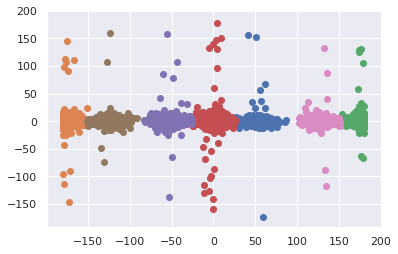

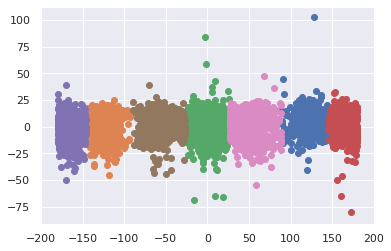

In [205]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

x_data_full = {'a':x_data_a, 'l':x_data_l}
y_data_full = {'a':y_data_a, 'l':y_data_l}
#x_data_full = {'a':x_data_a_future, 'l':x_data_l_future}
#y_data_full = {'a':y_data_a_future, 'l':y_data_l_future}
#x_data_full = {'a':np.linspace(0,10,100), 'l':np.linspace(0,10,100)}
#y_data_full = {'a':np.linspace(0,10,100), 'l':np.linspace(0,10,100)}
yhat = {'a':[], 'l':[]}
clusters = {'a':[], 'l':[]}
# define dataset
for m in ['a', 'l']:
    X = np.c_[x_data_full[m], y_data_full[m]]
    # define the model
    model = KMeans(n_clusters=7)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat[m] = model.predict(X)
    # retrieve unique clusters
    clusters[m] = np.unique(yhat[m])
    # create scatter plot for samples from each cluster
    
    for cluster in clusters[m]:
        # get row indexes for samples with this cluster
        row_ix = np.where(yhat[m] == cluster)
        # create scatter of these samples
        plt.scatter(X[row_ix,0], X[row_ix,1])
    # show the plot
    plt.show()


### fit linear regression on clusters for slope

In [206]:
from sklearn.linear_model import LinearRegression

X = {'a':[], 'l':[]}
a_sd = {'a':[], 'l':[]}
b_sd = {'a':[], 'l':[]}
boun = {'a':[], 'l':[]}
bounds = []
# create scatter plot for samples from each cluster
for m in ['a', 'l']:
    for cluster in clusters[m]:
        X[m].append(np.c_[x_data_full[m][np.where(yhat[m] == cluster)]])
        y = np.c_[y_data_full[m][np.where(yhat[m] == cluster)]]
        reg = LinearRegression().fit(X[m][cluster], y)

        a_sd[m].append(np.squeeze(reg.coef_))
        b_sd[m].append(reg.intercept_)
        boun[m].append(min(X[m][cluster]))
        if cluster==max(clusters[m]):# also append last bound
            #print(max(np.concatenate(X[m])))
            boun[m].append(max(np.concatenate(X[m])))
bounds = np.sort(np.concatenate(boun['l']))# only need one since same


#### plot linear regression slopes for each cluster

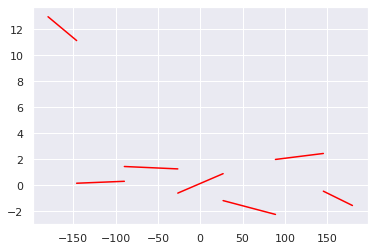

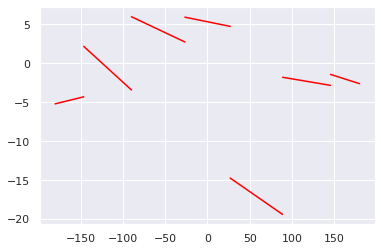

In [207]:
for m in ['a', 'l']:
    plt.figure()
    #plt.scatter(x_data_full[m],y_data_full[m])
    for i in clusters[m]:
        x = np.linspace(bounds[i], bounds[i+1], 100)
        plt.plot(x, a_sd[m][i]*x+b_sd[m][i], color='red')
    plt.show()


### moving average within each cluster

In [208]:
w1 = np.pi/10
w2 = np.pi/40

err_avg_cluster = {'a': [[] for i in clusters['a']], 'l': [[] for i in clusters['l']]}
err_sem_cluster = {'a': [[] for i in clusters['a']], 'l': [[] for i in clusters['l']]}
rel_loc_avg_cluster = {'a': [[] for i in clusters['a']], 'l': [[] for i in clusters['l']]}
for m in ['a', 'l']:
    for cluster in clusters[m]:
        err_avg_cluster[m][cluster], err_sem_cluster[m][cluster], rel_loc_avg_cluster[m][cluster] = mov_avg_comb(np.concatenate(rel_loc[m])[np.where(yhat[m] == cluster)], np.concatenate(err[m])[np.where(yhat[m] == cluster)], w1, w2)
        

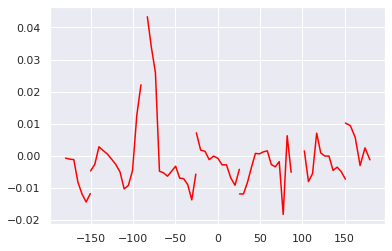

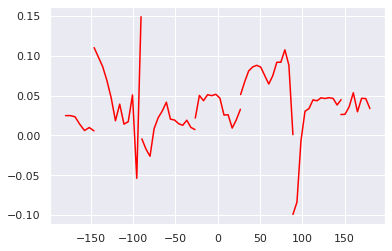

In [209]:
for m in ['a', 'l']:
    plt.figure()
    #plt.scatter(x_data_full[m],y_data_full[m])
    for cluster in clusters[m]:
        plt.plot(rel_loc_avg_cluster[m][cluster]*180/np.pi,err_avg_cluster[m][cluster], color='red')
    plt.show()